NATIONAL HOUSEHOLD SURVEY ON DRUG USE AND HEALTH (NSDUH), 2004 [ICPSR 4373] obejmuje 67 760 osób. Plik do użytku publicznego zawiera 55 602 rekordów ze względu na resampling stosowany w procesie anonimizacji. Próba jest stratyfikowana na wielu poziomach. Proces próbkowania respondentów był prowadzony w sposób systematyczny. Każdy respondent, który ukończył pełny wywiad, otrzymał 30 USD gotówki. W ramach analizy zamierzam przeprowadź eksploracje danych w znalezieniu kluczowych statystyk a następnie zbudować model do predykcji wystąpienia depresji oraz jej skali.

# Importowanie bibliotek

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.ticker import FuncFormatter
import ppscore as pps
import networkx as nx
from catboost import CatBoostClassifier, Pool
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import statsmodels.api as sm
from statsmodels.formula.api import ols
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import StandardScaler
from scipy.stats import f_oneway
from scipy.stats import kruskal
from sklearn.linear_model import LinearRegression
from sklearn.impute import KNNImputer, SimpleImputer
from sklearn.ensemble import RandomForestClassifier
import time
from scipy.stats import mannwhitneyu, kruskal
from scipy.stats import ks_2samp
from sklearn.decomposition import PCA
from sklearn.utils import resample
import xgboost as xgb
from sklearn.metrics import accuracy_score
from scipy.optimize import differential_evolution


pd.set_option('mode.chained_assignment', None)


# Wczytanie Danych

In [2]:
data = pd.read_csv('/home/krzysztof/Kaczmarek/Projket2/ICPSR_27521/DS0001/27521-0001-Data.tsv',sep='\t')

In [3]:
columns_to_check = [
    "DEPRESSIONINDEX", "DEP_EPISODE", "MDELastYr", "ANYTXRXMDE", 
    "CATAG2", "CATAG3", "CATAG7", "IRSEX", "NEWRACE2", "ANYINDEX", "YO_MDEA6",
    "MJANDCOKE", "ILLICITDRUGUSE", "LSYRILLICIT", "COKECRACK", "OTHERILLICIT", 
    "MARJLTYR", "MJCOKELY", "COCCRKLY", "MJGT12MO", "COCGT12MO", "ANYGT12MO", 
    "ALCFMFPB", "IREDUC2", "EDU_DUMMY", "INCOME", "INCOME_R", "POVERTY", 
    "IRPRVHLT", "WORKFORCE", "EMPSTAT4", "REVERSEPOP", "MOVESPY2", "CACHAR", 
    "CATYPE", "CRIMEHIST", "ANYSDRUG", "ANYATTACK", "ANYTHEFT", "NUMARREST", 
    "HEALTH2", "SCHDSICK", "SCHDSKIP", "TXLCAD", "DSTNCALM", "DSTTIRE", 
    "DSTSITST", "DSTDEPRS", "DSTCHEER", "DSTNRVOS", "YOWRSATP", "YOWRSPLN", 
    "ADWRDLOT", "ADWRSTHK", "YO_MDEA4", "ADWRSLEP", "ADWRSMOR", "YO_MDEA3", 
    "ADWRELES", "IRMARIT", "NOMARR2", "RKIDSHH", "MARRIED", "CHILDRENINHOME"
]

available_columns = [col for col in columns_to_check if col in data.columns]

df_filtered = data[available_columns]

# Rozkład danych w zmiennej DEPRESSIONINDEX

In [4]:

def plot_percentage_barplot(data,column_name):
    depression = data[column_name]
    if depression.isnull().sum() == 0:
        fig, axes = plt.subplots(1, 2, figsize=(16, 5))
        value_counts = depression.value_counts(dropna=False)
        labels = value_counts.index.to_series().fillna('Missing Data').astype(str)
        colors = plt.cm.Paired.colors[:len(value_counts)]
        
        axes[0].bar(labels, value_counts.values, color=colors) 
        axes[0].set_title(f'{column_name} - Bar Chart')
        axes[0].set_ylabel('Count')
        axes[0].set_xlabel(column_name)
        
        def autopct_format(pct):
            return f'{pct:.1f}%' if pct >= 2 else ''  

        axes[1].pie(
            value_counts.values, 
            labels=labels, 
            autopct=autopct_format, 
            startangle=90, 
            colors=colors
        )
        axes[1].set_title(f'{column_name} - Pie Chart')

        plt.tight_layout()
        plt.show()
    else:
        print(f"Występują brakujące wartości w kolumnie {column_name} w ilości: {depression.isnull().sum()}")

In [5]:
def plot_depression_heatmap(data, depression_col, category_col):
    grouped_data = data.groupby([category_col, depression_col]).size().reset_index(name='count')
    total_counts = grouped_data.groupby(category_col)['count'].sum().reset_index(name='total')
    grouped_data = pd.merge(grouped_data, total_counts, on=category_col)
    grouped_data['percentage'] = (grouped_data['count'] / grouped_data['total']) * 100

    pivot_table = grouped_data.pivot(index=category_col, columns=depression_col, values='percentage')

    plt.figure(figsize=(15, 5))
    sns.heatmap(
        pivot_table,
        annot=True,
        fmt='.1f',
        cmap='coolwarm',
        cbar_kws={'label': 'Procent [%]'}
    )
    plt.title(f'Heatmapa rozkładu {depression_col} względem {category_col}')
    plt.xlabel(depression_col)
    plt.ylabel(category_col)
    plt.tight_layout()
    plt.show()

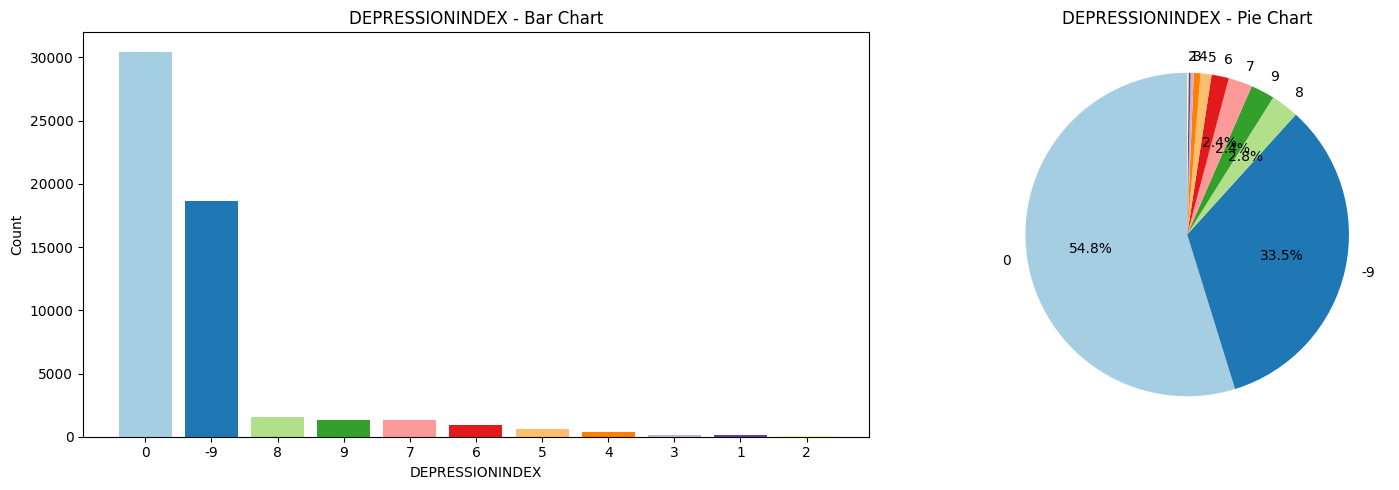

In [6]:
plot_percentage_barplot(df_filtered, 'DEPRESSIONINDEX')

In [7]:
df_filtered['DEPRESSIONINDEX'] = df_filtered['DEPRESSIONINDEX'].replace(-9, np.nan)
df_filtered = df_filtered.dropna(subset=['DEPRESSIONINDEX'])

Postanowiłem usunąć wszystkie rzędy z DEPRESSIONINDEX = -9

# Podział na depresje somatyczną i niesomatyczną

In [8]:
#YO_MDEA4 - 1-tak, 2-nie - Sen
#YO_MDEA3 - 1-tak, 2-nie - Apetyt
#YO_MDEA6 - 1-tak, 2-nie - Zmęczenie

df_filtered.loc[(df_filtered['DEPRESSIONINDEX'].between(1, 9)) & 
       (df_filtered['YO_MDEA4'] == 1) & 
       (df_filtered['YO_MDEA3'] == 1) & 
       (df_filtered['YO_MDEA6'] == 1), 'Somatic'] = 2

df_filtered.loc[(df_filtered['DEPRESSIONINDEX'] == 0), 'Somatic'] = 0

df_filtered.loc[(df_filtered['DEPRESSIONINDEX'].between(1, 9)) & 
       ((df_filtered['YO_MDEA4'] != 1) |
       (df_filtered['YO_MDEA3'] != 1) | 
       (df_filtered['YO_MDEA6'] != 1)), 'Somatic'] = 1

df_filtered['Somatic'].replace(np.nan, -1, inplace=True)

# Somatic - 2 - depresja somatyczn, 1 - brak depresji somatycznej, 0 - brak depresji

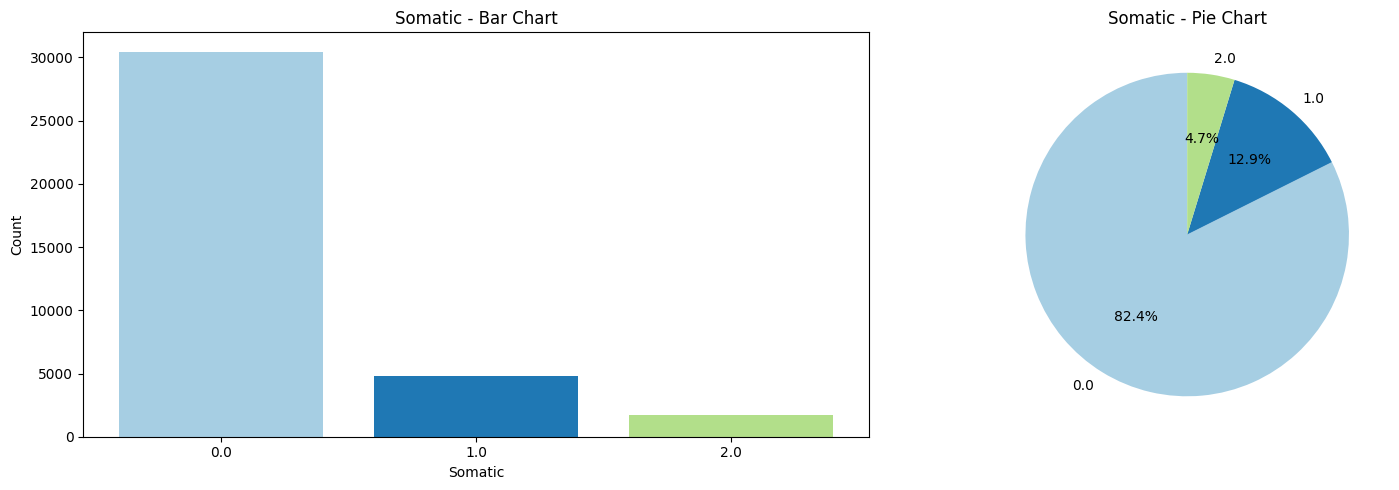

In [9]:
plot_percentage_barplot(df_filtered, 'Somatic')

2 - depresja somatyczn  
1 - brak depresji somatycznej  
0 - brak depresji

# Wizualizacje rozkładu innych zmiennych

## Płeć

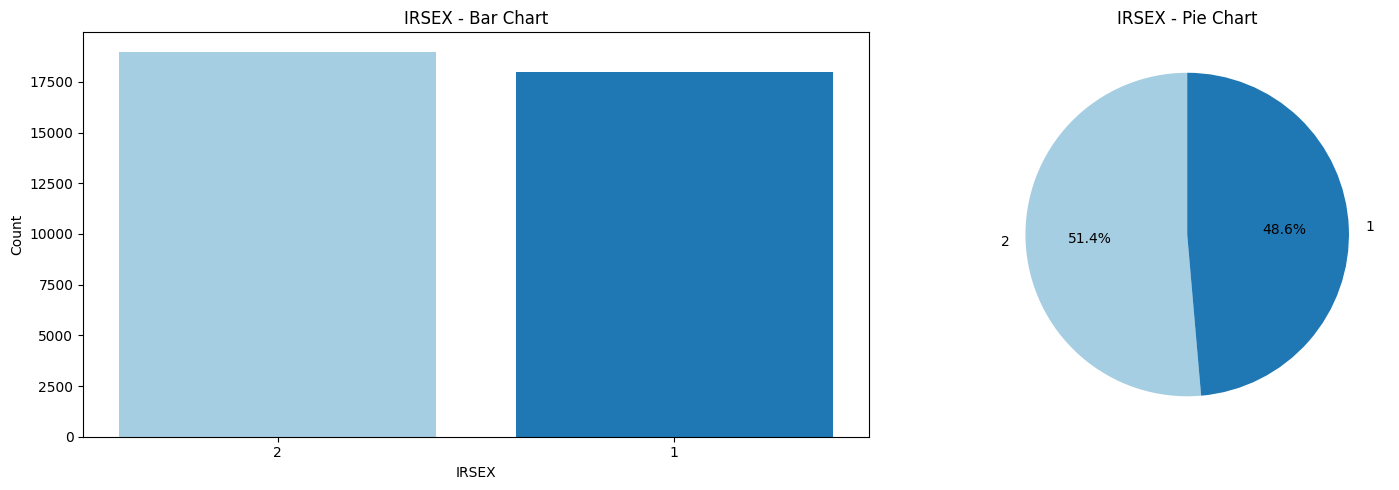

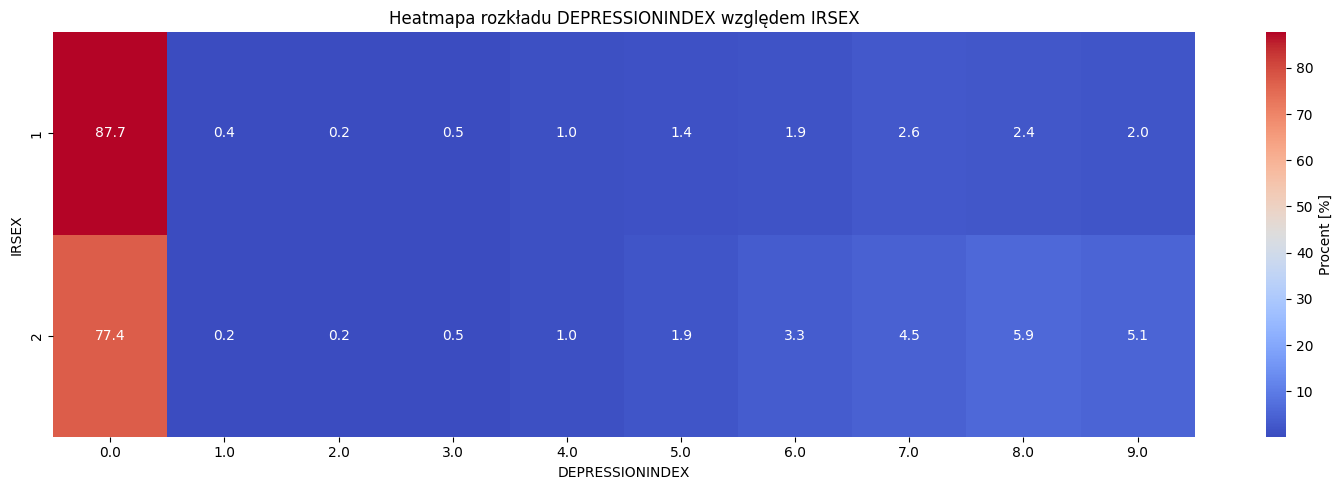

In [10]:
plot_percentage_barplot(df_filtered, 'IRSEX')
plot_depression_heatmap(df_filtered, 'DEPRESSIONINDEX', 'IRSEX')

## Rasa

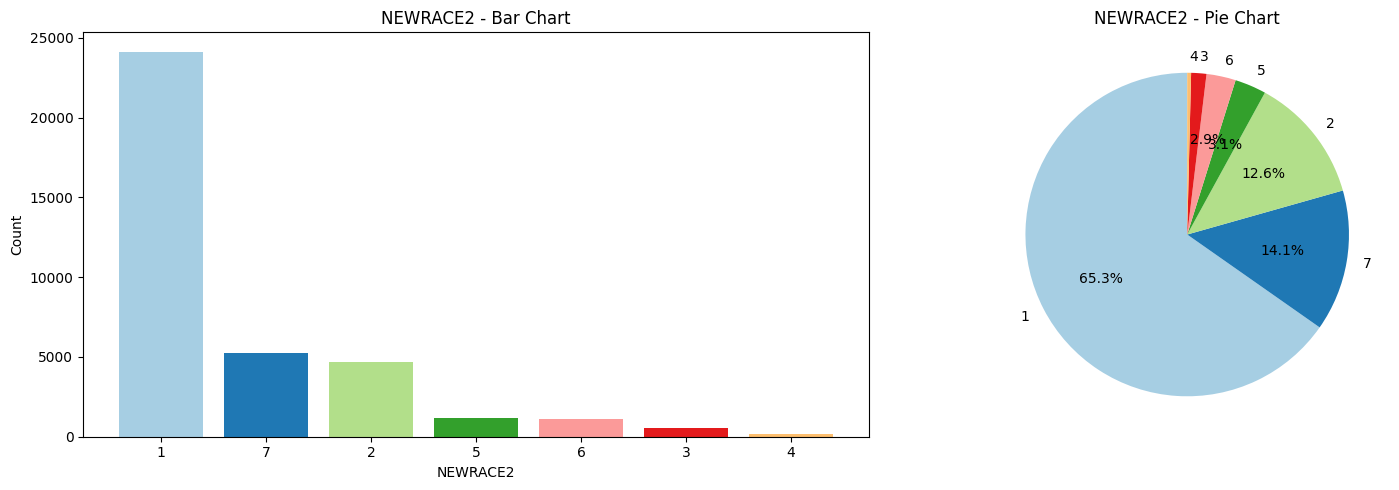

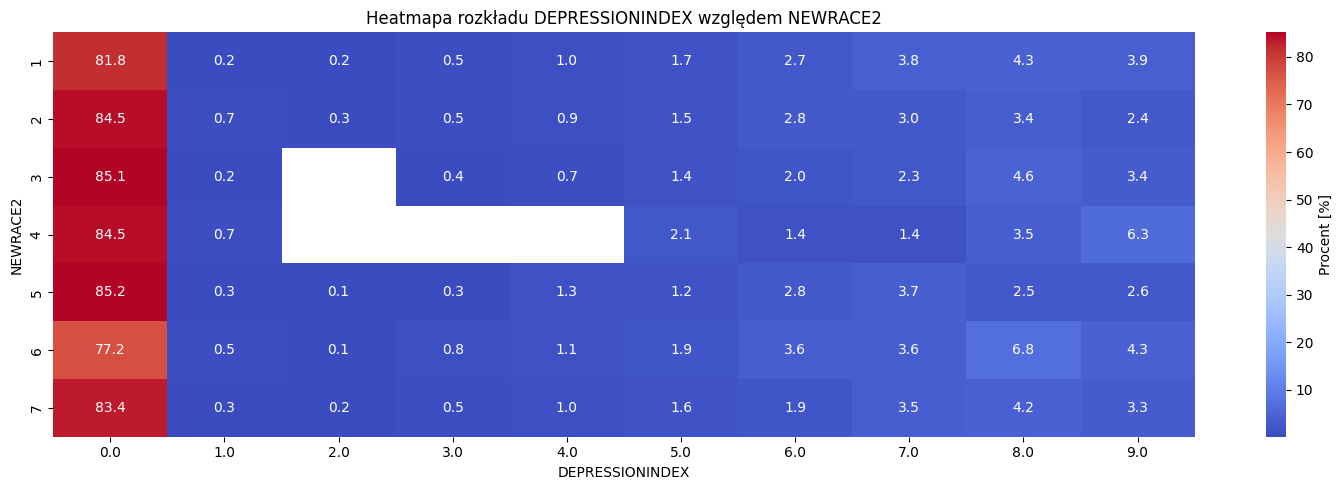

In [11]:
plot_percentage_barplot(df_filtered, 'NEWRACE2')
plot_depression_heatmap(df_filtered, 'DEPRESSIONINDEX', 'NEWRACE2')

## Grupa wiekowa

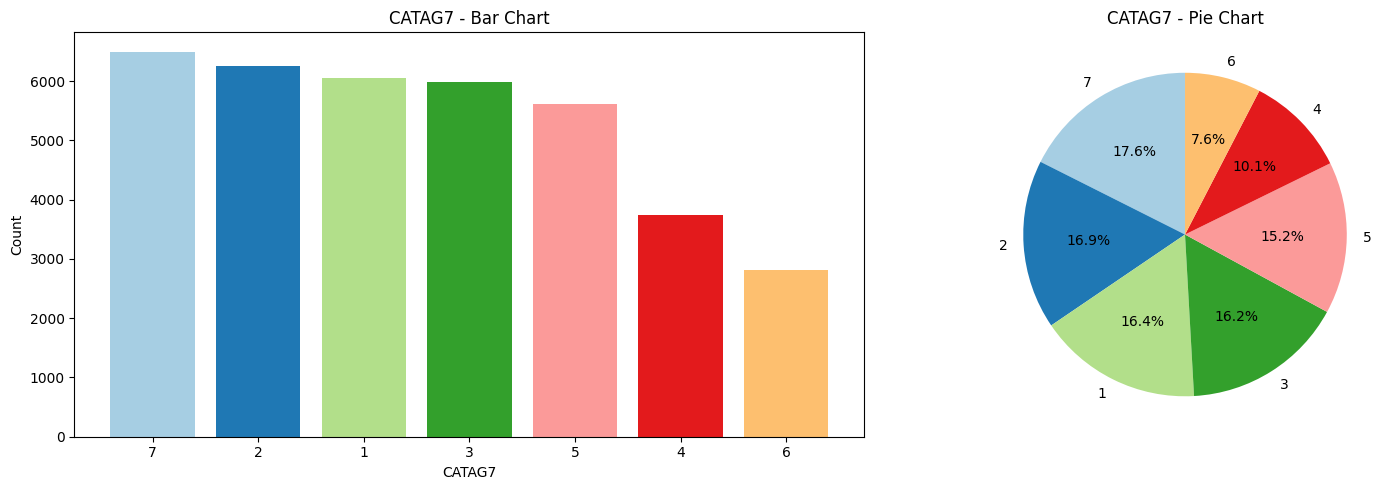

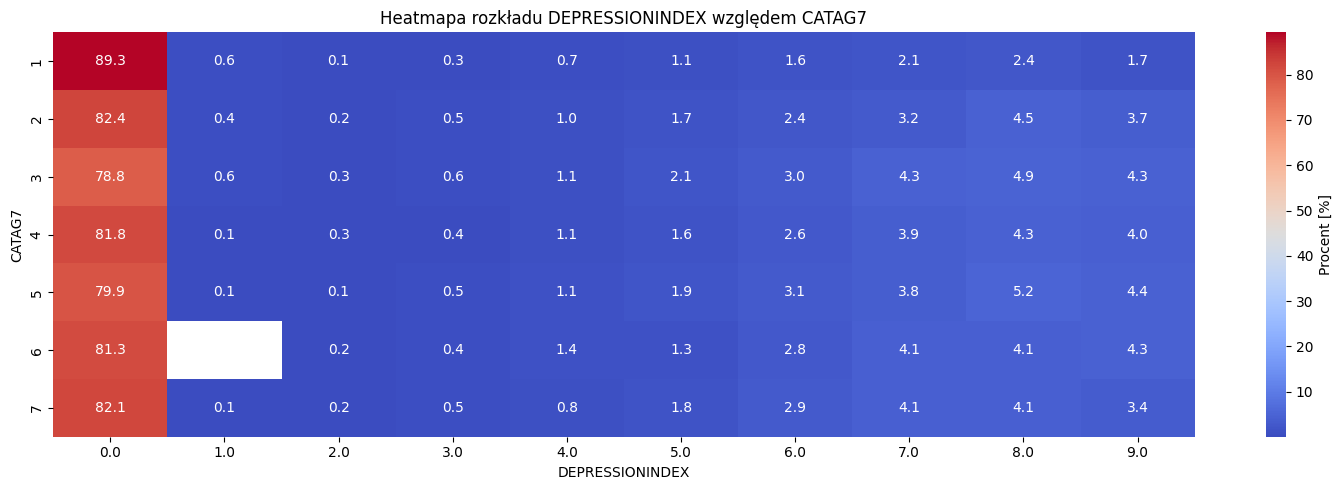

In [12]:
plot_percentage_barplot(df_filtered, 'CATAG7')
plot_depression_heatmap(df_filtered, 'DEPRESSIONINDEX', 'CATAG7')

## Poziom edukacji

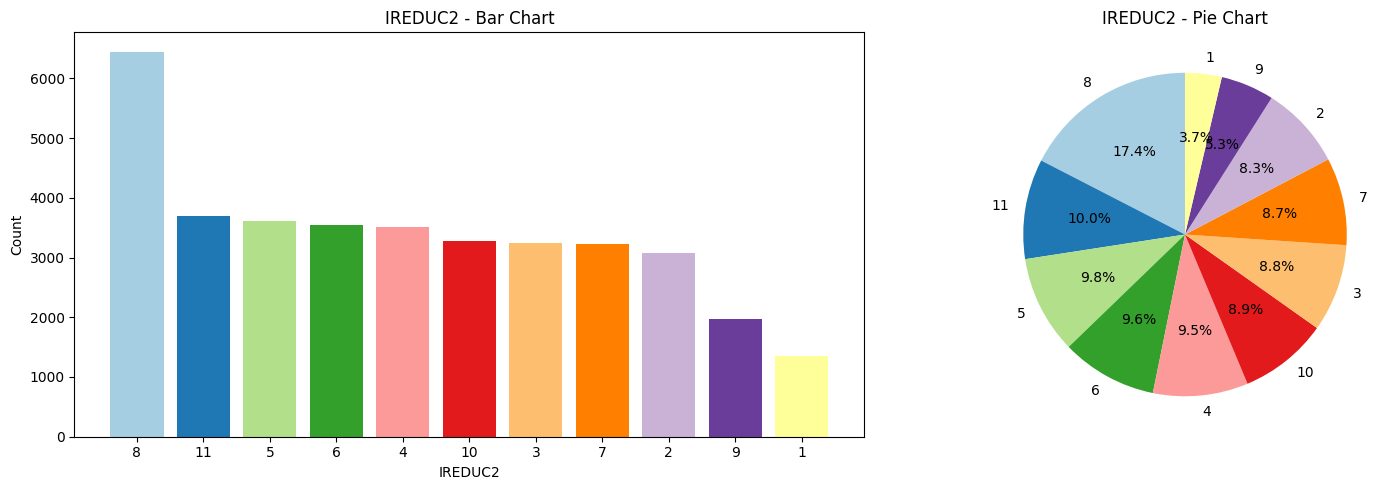

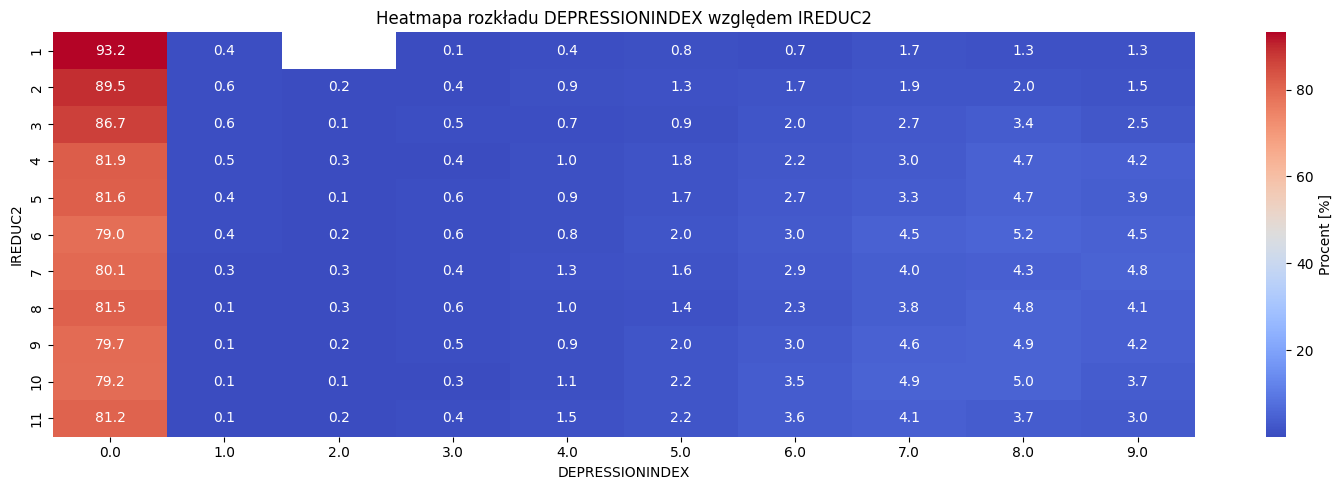

In [13]:
plot_percentage_barplot(df_filtered, 'IREDUC2')
plot_depression_heatmap(df_filtered, 'DEPRESSIONINDEX', 'IREDUC2')

# Operacje na brakach w danych

## Sprawdzenie które kolumny występują tylko dla pozytywnych wartości w DEPRESSIONINDEX

In [14]:
pd.set_option('display.max_rows', None)

check_nan_data = df_filtered.copy()

check_nan_data[check_nan_data == -1] = np.nan
check_nan_data[check_nan_data == -9] = np.nan

check_nan_data['YO_MDEA4'].replace([99, 98, 94, 97], np.nan, inplace=True)
check_nan_data['MOVESPY2'].replace([998, 997, 994], np.nan, inplace=True)
check_nan_data['SCHDSKIP'].replace([89, 94, 97, 98, 99], np.nan, inplace=True)
check_nan_data['SCHDSICK'].replace([89, 90, 94, 97, 98, 99], np.nan, inplace=True)
check_nan_data['ALCFMFPB'].replace([94, 97, 98], np.nan, inplace=True)
check_nan_data['ADWRSTHK'].replace([94, 97, 98, 99], np.nan, inplace=True)
check_nan_data['NOMARR2'].replace([94, 97, 99], np.nan, inplace=True)
check_nan_data['ADWRELES'].replace([94, 97, 98, 99], np.nan, inplace=True)
check_nan_data['YO_MDEA3'].replace([94, 97, 98, 99], np.nan, inplace=True)
check_nan_data['YO_MDEA6'].replace([94, 97, 98, 99], np.nan, inplace=True)
check_nan_data['ADWRSMOR'].replace([94, 97, 98, 99], np.nan, inplace=True)
check_nan_data['ADWRSLEP'].replace([94, 97, 98, 99], np.nan, inplace=True)
check_nan_data['ADWRDLOT'].replace([94, 97, 98, 99], np.nan, inplace=True)
check_nan_data['YOWRSPLN'].replace([94, 97, 98, 99], np.nan, inplace=True)
check_nan_data['YOWRSATP'].replace([94, 97, 98, 99], np.nan, inplace=True)
check_nan_data['DSTNRVOS'].replace([85, 89, 94, 97, 98, 99], np.nan, inplace=True)
check_nan_data['DSTCHEER'].replace([85, 94, 97, 98, 99], np.nan, inplace=True)
check_nan_data['DSTDEPRS'].replace([89, 94, 97, 98, 99], np.nan, inplace=True)
check_nan_data['DSTSITST'].replace([94, 97, 98, 99], np.nan, inplace=True)
check_nan_data['DSTTIRE'].replace([89, 94, 97, 98, 99], np.nan, inplace=True)
check_nan_data['DSTNCALM'].replace([94, 97, 98, 99], np.nan, inplace=True)

missing_percentage = check_nan_data.isna().mean() * 100


In [15]:
missing_percentage_without_depression = check_nan_data[check_nan_data['DEPRESSIONINDEX'] == 0].isna().mean() * 100
missing_percentage_with_depression = check_nan_data[check_nan_data['DEPRESSIONINDEX'] != 0].isna().mean() * 100

In [16]:
comparison_df = pd.DataFrame({
    'Column': missing_percentage_without_depression.index,
    'Without Depression': missing_percentage_without_depression.values,
    'With Depression': missing_percentage_with_depression.values,
    'Overall': missing_percentage.values,
    'Difference': missing_percentage_with_depression.values - missing_percentage_without_depression.values
})
comparison_df = comparison_df.sort_values(by='Overall', ascending=False)
comparison_df[comparison_df['Without Depression'] == 100]

,Column,Without Depression,With Depression,Overall,Difference
42,DSTNCALM,100.0,100.000000,100.000000,0.000000
45,DSTDEPRS,100.0,100.000000,100.000000,0.000000
43,DSTTIRE,100.0,100.000000,100.000000,0.000000
44,DSTSITST,100.0,100.000000,100.000000,0.000000
54,ADWRSMOR,100.0,90.204207,98.274370,-9.795793
48,YOWRSATP,100.0,77.982497,96.121389,-22.017503
49,YOWRSPLN,100.0,77.890373,96.105161,-22.109627
55,YO_MDEA3,100.0,55.688623,92.194093,-44.311377
52,YO_MDEA4,100.0,55.489022,92.158931,-44.510978
8,YO_MDEA6,100.0,55.396899,92.142703,-44.603101


In [17]:
comparison_df = comparison_df[comparison_df['Difference'].abs() > 10]
Depression_column=comparison_df['Column'].values.tolist()
Depression_column

['YOWRSATP',
 'YOWRSPLN',
 'YO_MDEA3',
 'YO_MDEA4',
 'YO_MDEA6',
 'ADWRELES',
 'ADWRSLEP',
 'ADWRSTHK',
 'ADWRDLOT']

Jak widać występuje kilka kolumn dla których dane zbierane były tylko gdy osoba miała depresje 

## Usunięcie kolumn gdzie występuje ponad 60% danych brakujących

In [18]:
columns_to_drop = missing_percentage[(missing_percentage > 60)].index

for column in Depression_column:
    if column in columns_to_drop:
        columns_to_drop = columns_to_drop.drop(column)

check_nan_data.drop(columns=columns_to_drop, inplace=True)

df_filtered = check_nan_data
df_filtered['DEPRESSIONINDEX'] = df_filtered['DEPRESSIONINDEX'].astype(int)

df_filtered_without_DEPRESSIONINDEX = check_nan_data.drop(columns=['DEPRESSIONINDEX'])

## Uzupełnienie brakujących danych

In [19]:
df_filtered.drop(columns=['SCHDSICK', 'SCHDSKIP', 'DSTCHEER', 'DSTNRVOS'], inplace=True)
column_with_missing_values = df_filtered.columns[df_filtered.isna().any()].tolist()

column_with_missing_values

['ANYTXRXMDE',
 'ANYINDEX',
 'YO_MDEA6',
 'COKECRACK',
 'MJGT12MO',
 'COCGT12MO',
 'ANYGT12MO',
 'ALCFMFPB',
 'WORKFORCE',
 'MOVESPY2',
 'CACHAR',
 'CATYPE',
 'CRIMEHIST',
 'ANYSDRUG',
 'ANYATTACK',
 'ANYTHEFT',
 'NUMARREST',
 'HEALTH2',
 'YOWRSATP',
 'YOWRSPLN',
 'ADWRDLOT',
 'ADWRSTHK',
 'YO_MDEA4',
 'ADWRSLEP',
 'YO_MDEA3',
 'ADWRELES',
 'RKIDSHH']

In [20]:
columns_without_missing_values = df_filtered.columns[~df_filtered.isna().any()]
df_without_missing_values = df_filtered[columns_without_missing_values]

X = df_without_missing_values.drop(columns=['DEPRESSIONINDEX']) 
y = df_without_missing_values['DEPRESSIONINDEX']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = LinearRegression()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)

print(f'Mean Squared Error: {mse}')

method = 0
low_mse = 1000

def impute_missing_values(df, column):
    low_mse = 1000
    for method in range(3):
        # print(f'Column: {column} - Method: {method}')
        if method == 0:
            imputer = SimpleImputer(strategy='median')
        if method == 1:
            imputer = SimpleImputer(strategy='mean')
        if method == 2:
            imputer = KNNImputer(n_neighbors=3)

        df_sampled = df_without_missing_values.sample(frac=0.2, random_state=42)

        df_imputed = pd.DataFrame(imputer.fit_transform(df_sampled), columns=df_sampled.columns)

        X = df_imputed.drop(columns=['DEPRESSIONINDEX']) 
        y = df_imputed['DEPRESSIONINDEX']
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
        
        model = LinearRegression()
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        mse = mean_squared_error(y_test, y_pred)

        if mse < low_mse:
            low_mse = mse
            best_method = imputer

        method += 1

    return low_mse, best_method


for column in column_with_missing_values:
    df_without_missing_values = pd.concat([df_without_missing_values, df_filtered[column]], axis=1)
    mse, imputer = impute_missing_values(df_without_missing_values, column)
    print(f'Mean Squared Error: {mse}, Method: {imputer}, Column: {column}')
    df_without_missing_values[column] = imputer.fit_transform(df_without_missing_values[[column]])



Mean Squared Error: 0.9486102800793997
Mean Squared Error: 0.8321745694830879, Method: SimpleImputer(strategy='median'), Column: ANYTXRXMDE
Mean Squared Error: 0.8278366752457478, Method: SimpleImputer(strategy='median'), Column: ANYINDEX
Mean Squared Error: 0.769705009536673, Method: KNNImputer(n_neighbors=3), Column: YO_MDEA6
Mean Squared Error: 0.8050368179190681, Method: KNNImputer(n_neighbors=3), Column: COKECRACK
Mean Squared Error: 0.8077855634990609, Method: SimpleImputer(), Column: MJGT12MO
Mean Squared Error: 0.8069356014990504, Method: SimpleImputer(), Column: COCGT12MO
Mean Squared Error: 0.8069581660993347, Method: SimpleImputer(strategy='median'), Column: ANYGT12MO
Mean Squared Error: 0.8065621094348847, Method: SimpleImputer(), Column: ALCFMFPB
Mean Squared Error: 0.8065054295704441, Method: SimpleImputer(strategy='median'), Column: WORKFORCE
Mean Squared Error: 0.8065479468158726, Method: KNNImputer(n_neighbors=3), Column: MOVESPY2
Mean Squared Error: 0.8060855648532406

Kod świetnie spełnia swoje zadanie podchodząc do każdej z kolumn w sposób indywidualny i wybierając dla niej najlepszy sposób uzupelniania danych

In [21]:
column_with_missing_values = df_without_missing_values.columns[df_without_missing_values.isna().any()].tolist()
nan_counts = df_without_missing_values[column_with_missing_values].isna().sum()
nan_counts

Series([], dtype: float64)

In [22]:
num_columns = df_without_missing_values.shape[1]
print(num_columns)

num_columns = df_filtered.shape[1]
print(num_columns)

df_filtered = df_without_missing_values.copy()

52
52


# Predictive Power Score dla zmiennej DEPRESSIONINDEX

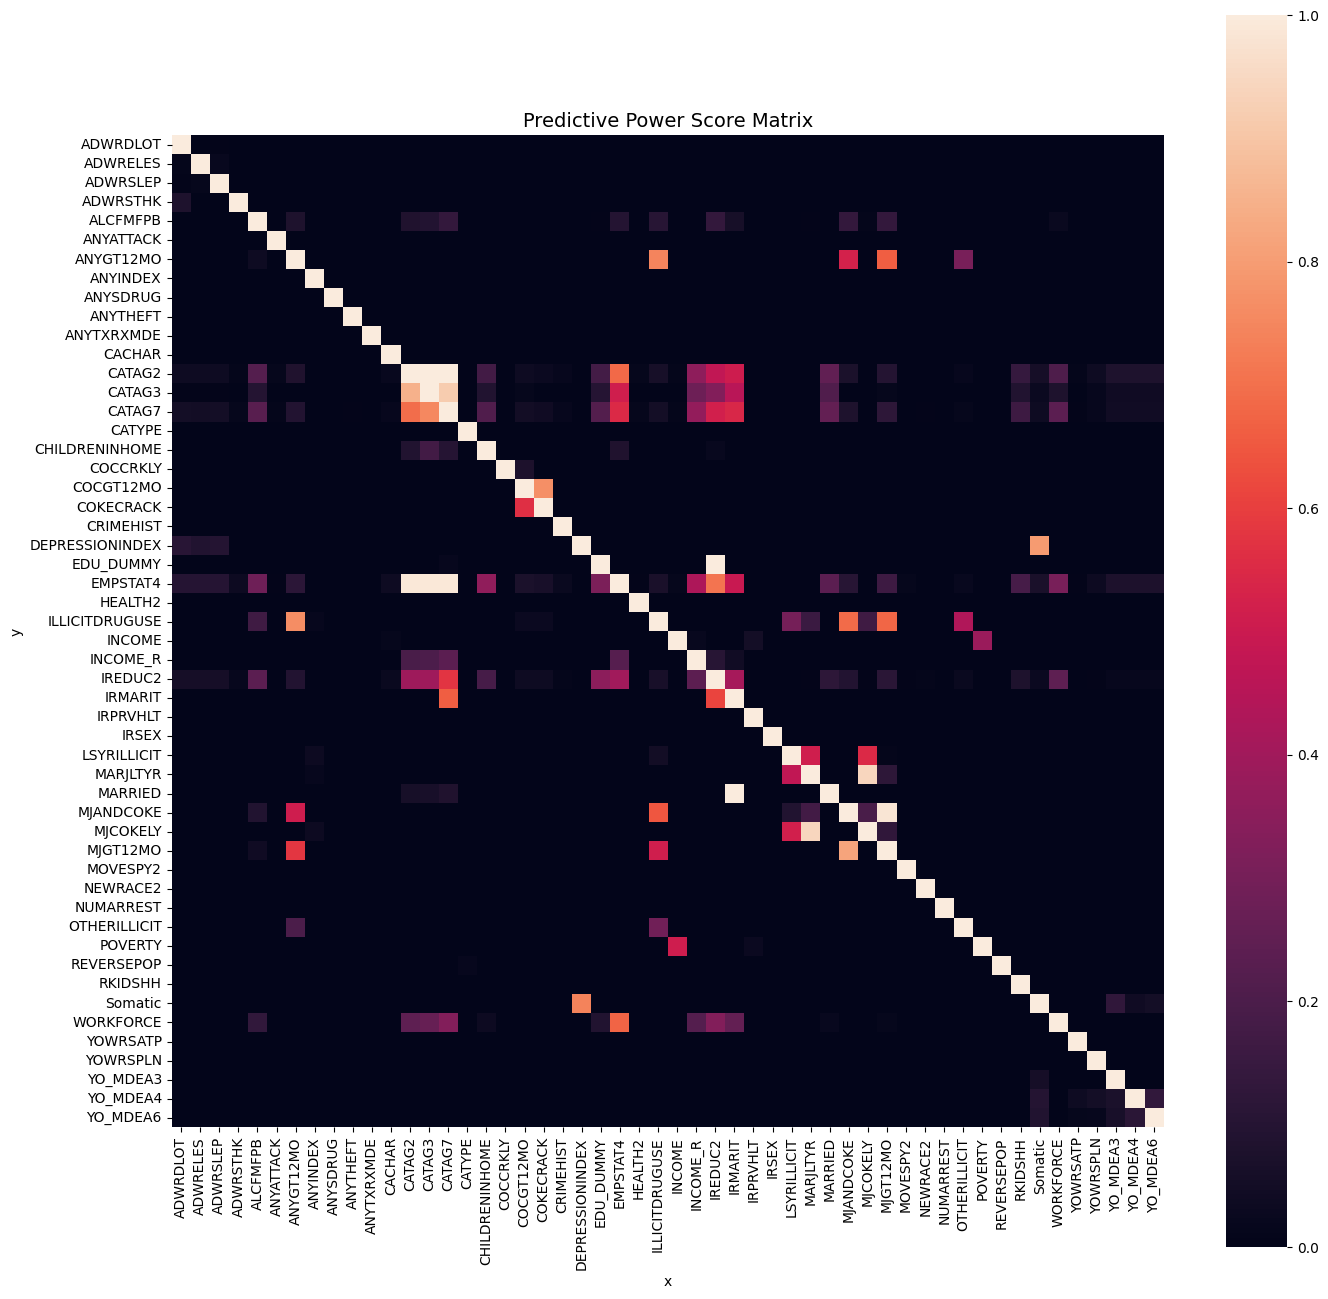

In [23]:
pps_matrix = pps.matrix(df_filtered)
pps_matrix = pps_matrix[['x', 'y', 'ppscore']].pivot(columns='x', index='y', values='ppscore')
plt.figure(figsize=(16, 16))
sns.heatmap(pps_matrix, vmin=0, vmax=1,square=True)
plt.title('Predictive Power Score Matrix', fontsize=14)
plt.show()

In [24]:
depression_pps_colums = pps_matrix[pps_matrix.columns == 'DEPRESSIONINDEX']
depression_pps_colums = depression_pps_colums.loc[:, depression_pps_colums.ne(0).any(axis=0)]
depression_pps_colums


x,ADWRDLOT,ADWRELES,ADWRSLEP,DEPRESSIONINDEX,Somatic
y,,,,,
DEPRESSIONINDEX,0.105941,0.089003,0.095438,1.0,0.796583


Kożystając z kolumn ADWRDLOT, ADWRELES, ADWRSLEP jesteśmy w stanie bezpośrednio przewidywać wartość DEPRESSIONINDEX postanowiłem ich na razie nie usuwać ponieważ są użyteczne do przewidywania skali depresji lecz w celu stworzenia modelu przewidującego  jest/nie ma depresji zmienne zostaną usunięte

In [25]:
features_to_drop = ['ANYTXRXMDE']
df_filtered_without_DEPRESSIONINDEX = df_filtered_without_DEPRESSIONINDEX.drop(columns=features_to_drop)
df_filtered = df_filtered.drop(columns=features_to_drop)

Nawet że PPS nie wykazał związku DEPRESSIONINDEX z ANYTXRXMDE postanawiam usunąć tą kolumne ze względu na możliwe przecieki danych

# Korelacja Cech

## Wyznaczenie macierzy korelacji

In [26]:
df_filtered_without_DEPRESSIONINDEX.shape

(36972, 54)

In [27]:
correlation_matrix = df_filtered_without_DEPRESSIONINDEX.corr(method='pearson')
# plt.figure(figsize=(15, 15))
# sns.heatmap(correlation_matrix, fmt=".2f")
# plt.title("Pearson Correlation Matrix",fontsize=14)
# plt.show()

correlation_matrix2 = df_filtered_without_DEPRESSIONINDEX.corr(method='spearman')
# plt.figure(figsize=(15, 15))
# sns.heatmap(correlation_matrix2, fmt=".2f")
# plt.title("Spearman Correlation Matrix",fontsize=14)
# plt.show()


In [28]:
corr_threshold = 0.8
corr_pairs = (correlation_matrix.abs() > corr_threshold) & (correlation_matrix < 1)
corr_pairs = corr_pairs.unstack().reset_index()
corr_pairs = corr_pairs[corr_pairs[0]]
corr_pairs = corr_pairs[corr_pairs.level_0 < corr_pairs.level_1]
corr_pairs = corr_pairs.rename(columns={"level_0": "Feature 1", "level_1": "Feature 2", 0: "Correlation"})

corr_pairs2 = (correlation_matrix2.abs() > corr_threshold) & (correlation_matrix2 < 1)
corr_pairs2 = corr_pairs2.unstack().reset_index()
corr_pairs2 = corr_pairs2[corr_pairs2[0]]
corr_pairs2 = corr_pairs2[corr_pairs2.level_0 < corr_pairs2.level_1]
corr_pairs2 = corr_pairs2.rename(columns={"level_0": "Feature 1", "level_1": "Feature 2", 0: "Correlation"})

corr_pairs = pd.concat([corr_pairs, corr_pairs2])
corr_pairs = corr_pairs.drop_duplicates()


## Grupowanie zmiennych zależnych i redukcja cech

In [29]:

graph = nx.Graph()

features = pd.concat([corr_pairs['Feature 1'], corr_pairs['Feature 2']]).unique()
graph.add_nodes_from(features)

edges = corr_pairs[['Feature 1', 'Feature 2']].values
graph.add_edges_from(edges)

connected_components = list(nx.connected_components(graph))

groups_df = pd.DataFrame({
    "Group": [f"Group {i+1}" for i in range(len(connected_components))],
    "Features": [", ".join(sorted(component)) for component in connected_components]
})

pd.set_option('display.max_colwidth', None)
groups_df


,Group,Features
0,Group 1,"CATAG2, CATAG3, CATAG7, EMPSTAT4, IREDUC2, IRMARIT"
1,Group 2,"ANYGT12MO, ILLICITDRUGUSE, MJANDCOKE, MJGT12MO"
2,Group 3,"LSYRILLICIT, MARJLTYR, MJCOKELY"


In [30]:
depression_corr1 = df_filtered.corr(method='pearson')['DEPRESSIONINDEX'].abs()
depression_corr2 = df_filtered.corr(method='spearman')['DEPRESSIONINDEX'].abs()

combined_corr = pd.concat([depression_corr1, depression_corr2], axis=1).max(axis=1)
combined_corr.sort_values(ascending=False, inplace=True)
combined_corr

DEPRESSIONINDEX    1.000000
Somatic            0.993431
YO_MDEA4           0.499338
ADWRSTHK           0.469481
YO_MDEA6           0.464604
ADWRSLEP           0.459295
YO_MDEA3           0.317236
YOWRSATP           0.306543
OTHERILLICIT       0.183496
ILLICITDRUGUSE     0.182700
ADWRELES           0.172675
ANYGT12MO          0.164626
MJANDCOKE          0.149675
IRSEX              0.148019
MJGT12MO           0.142717
LSYRILLICIT        0.136487
ANYINDEX           0.130577
HEALTH2            0.112893
MJCOKELY           0.102968
COCGT12MO          0.100394
MARJLTYR           0.099455
COKECRACK          0.098972
ANYATTACK          0.096989
ADWRDLOT           0.094046
ALCFMFPB           0.081427
IRMARIT            0.079328
IREDUC2            0.072569
COCCRKLY           0.061653
MOVESPY2           0.061419
ANYTHEFT           0.059162
CRIMEHIST          0.057658
CATAG7             0.050720
ANYSDRUG           0.050480
WORKFORCE          0.036760
EMPSTAT4           0.035647
NUMARREST          0

In [31]:
best_features = []
for group in connected_components:
    group_corr = combined_corr[list(group)]  
    best_feature = group_corr.idxmax()  
    best_features.append(best_feature)

best_features_df = pd.DataFrame({
    "Group": [f"Group {i+1}" for i in range(len(best_features))],
    "Best Feature": best_features
})

best_features_df

,Group,Best Feature
0,Group 1,IRMARIT
1,Group 2,ILLICITDRUGUSE
2,Group 3,LSYRILLICIT


In [32]:
all_unique_features = list(set([feature for group in connected_components for feature in group]))
features_to_drop = list(set(all_unique_features) - set(best_features))
features_to_drop

['MJGT12MO',
 'CATAG3',
 'MJCOKELY',
 'IREDUC2',
 'EMPSTAT4',
 'MJANDCOKE',
 'MARJLTYR',
 'ANYGT12MO',
 'CATAG2',
 'CATAG7']

# Podział na zbiór do predykcji depresji i zbiór do predykcji skali depresji

In [33]:
new_correlation_matrix = df_filtered.drop(columns=features_to_drop)

interesting_columns = []

In [34]:
Depression_column

['YOWRSATP',
 'YOWRSPLN',
 'YO_MDEA3',
 'YO_MDEA4',
 'YO_MDEA6',
 'ADWRELES',
 'ADWRSLEP',
 'ADWRSTHK',
 'ADWRDLOT']

In [35]:
df_filtered_for_depressio_scale = new_correlation_matrix.copy()
for column in Depression_column:
    if column in new_correlation_matrix.columns:
        new_correlation_matrix.drop(columns=column, inplace=True)

new_correlation_matrix.drop(columns=['Somatic'], inplace=True)

In [36]:
print(new_correlation_matrix.shape)
print(df_filtered_for_depressio_scale.shape)

(36972, 31)
(36972, 41)


# Wybór kluczowych cech dla modelu predykcji depresji

## Korelacja "spearman" dla cech najbardziej skorelowanych z DEPRESSIONINDEX

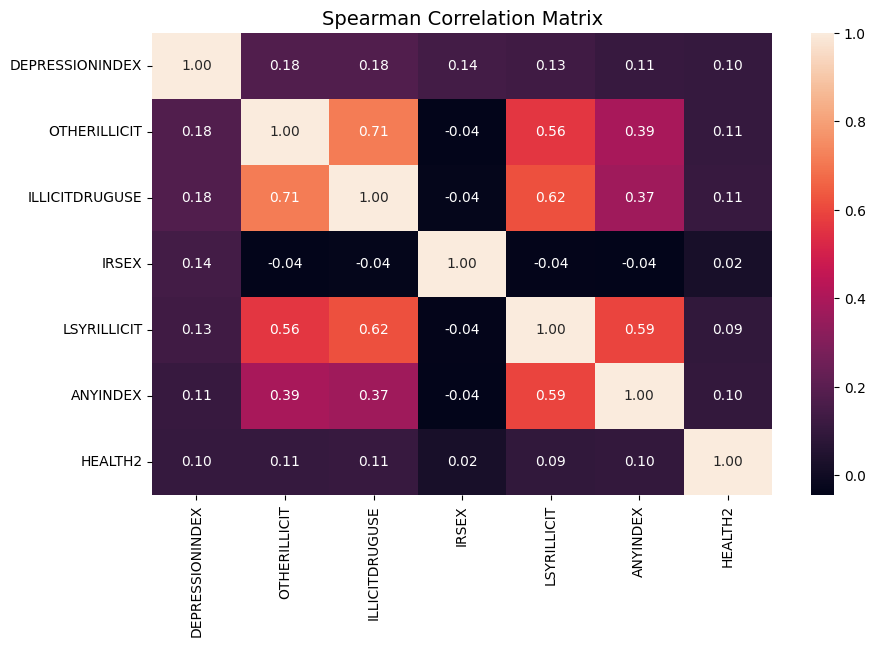

In [37]:
list_to_check = new_correlation_matrix.corr(method='spearman')['DEPRESSIONINDEX'].abs().sort_values(ascending=False)
list_to_check_new = list_to_check[:7].index.tolist()
interesting_columns.append(list_to_check_new)
corr_data = new_correlation_matrix[list_to_check_new]
corr_data.corr(method='spearman')
plt.figure(figsize=(10, 6))
sns.heatmap(corr_data.corr(method='spearman'), fmt=".2f", annot=True)
plt.title("Spearman Correlation Matrix",fontsize=14)
plt.show()

## Test Manna-Whitneya dla danych binarnych i DEPRESSIONINDEX

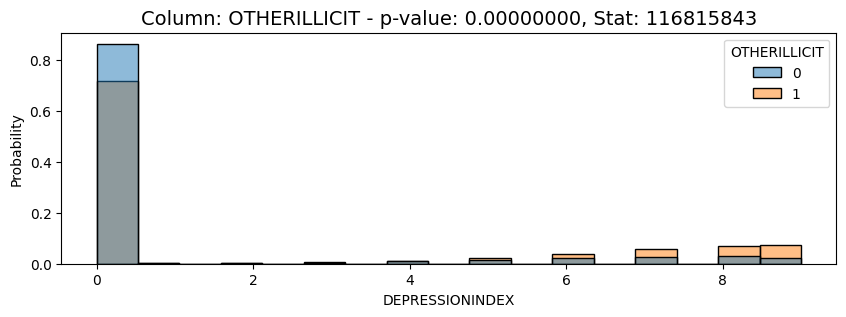

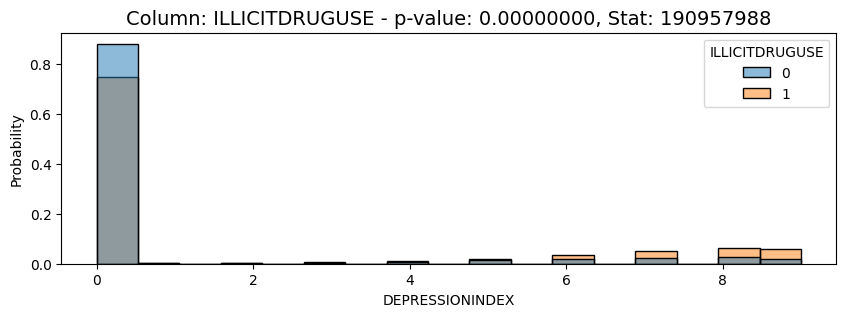

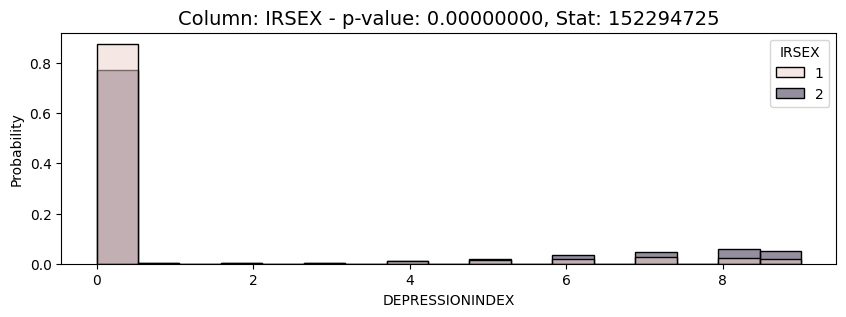

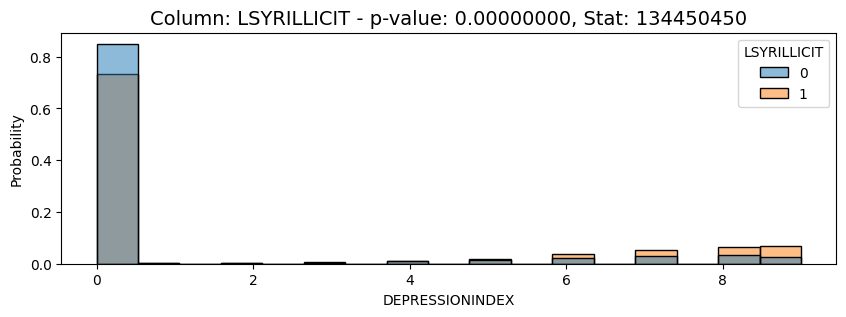

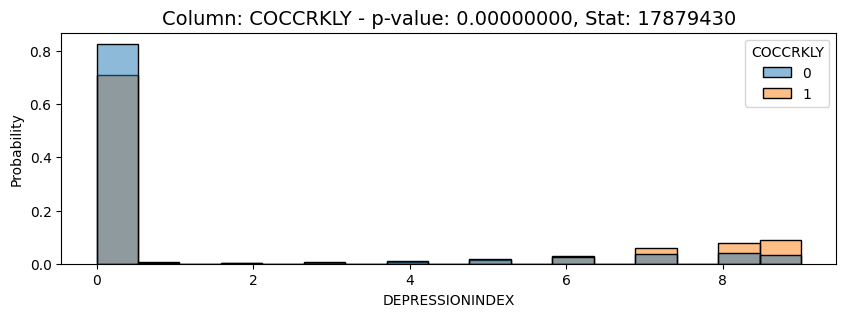

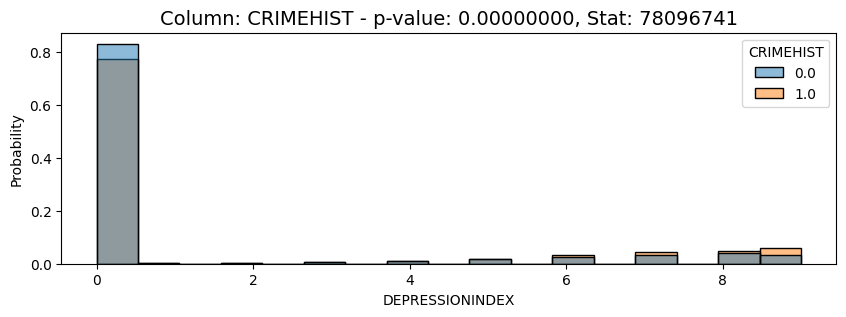

In [38]:
df_filtered = new_correlation_matrix

p_values = []

for column in df_filtered.columns:
    if column != 'DEPRESSIONINDEX':
        unique_values = df_filtered[column].unique()
        if len(unique_values) == 2:  
            group1 = df_filtered[df_filtered[column] == unique_values[0]]['DEPRESSIONINDEX']
            group2 = df_filtered[df_filtered[column] == unique_values[1]]['DEPRESSIONINDEX']
            stat, p_value = mannwhitneyu(group1, group2)
            p_values.append((column, p_value))


p_values_sorted = sorted(p_values, key=lambda x: x[1])
top_5_features = p_values_sorted[:6]
interesting_columns.append([column for column, p_value in top_5_features])
for column, p_value in top_5_features:
        if column != 'DEPRESSIONINDEX':
            unique_values = df_filtered[column].unique()
            group1 = df_filtered[df_filtered[column] == unique_values[0]]['DEPRESSIONINDEX']
            group2 = df_filtered[df_filtered[column] == unique_values[1]]['DEPRESSIONINDEX']
            stat, p_value = mannwhitneyu(group1, group2)
            title = f'Column: {column} - p-value: {p_value:.8f}, Stat: {stat:.0f}'   

            plt.figure(figsize=(10, 3))
            sns.histplot(df_filtered, x='DEPRESSIONINDEX', hue=column, stat='probability', common_norm=False)
            plt.title(title, fontsize=14)
            plt.show()
            


Jak widać na wykresach każda z 6 zmiennych jest istotna statystycznie i wystepują istotne różnice miedzy grupami

## Test Kruskala-Wallisa dla danych kategorycznych i DEPRESSIONINDEX

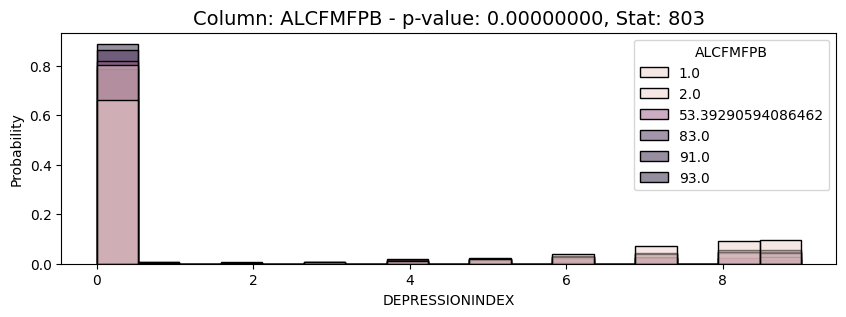

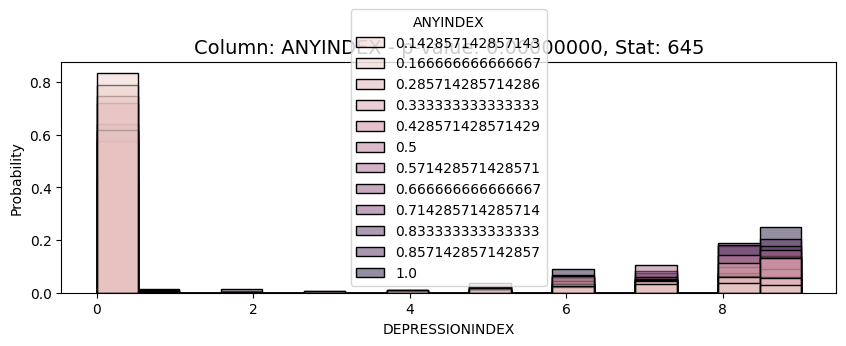

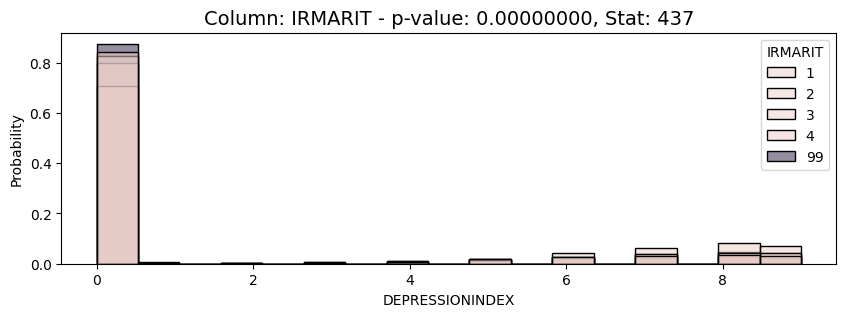

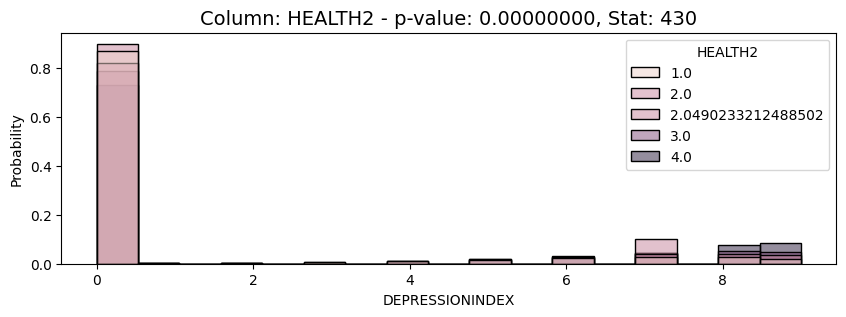

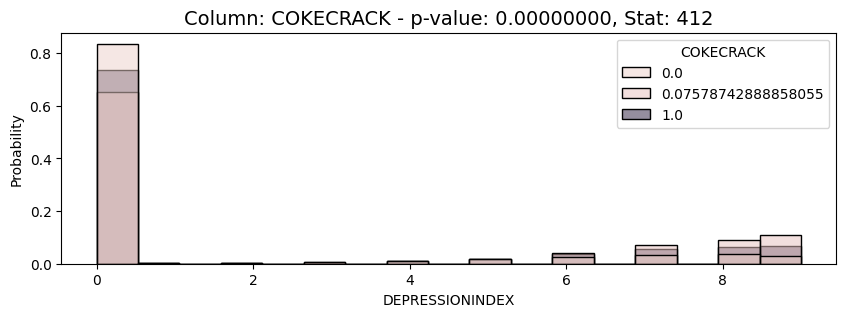

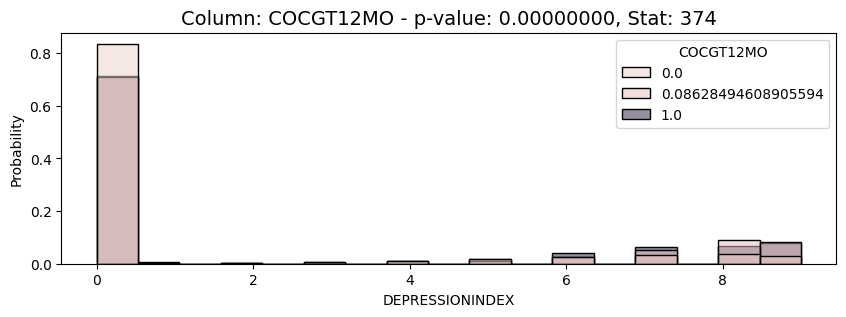

In [39]:
df_filtered = new_correlation_matrix
y = df_filtered['DEPRESSIONINDEX']
p_values = []

for column in df_filtered.columns:
    if column != 'DEPRESSIONINDEX':
        unique_values = df_filtered[column].unique()
        if len(unique_values) > 2:
            groups = [df_filtered[df_filtered[column] == value]['DEPRESSIONINDEX'] for value in unique_values]
            stat, p_value = kruskal(*groups)
            p_values.append((column, p_value))

p_values_sorted = sorted(p_values, key=lambda x: x[1])
top_5_features = p_values_sorted[:6]
interesting_columns.append([column for column, p_value in top_5_features])
for column, p_value in top_5_features:
        if column != 'DEPRESSIONINDEX':
            unique_values = df_filtered[column].unique()
            groups = [df_filtered[df_filtered[column] == value]['DEPRESSIONINDEX'] for value in unique_values]
            stat, p_value = kruskal(*groups)
            title = f'Column: {column} - p-value: {p_value:.8f}, Stat: {stat:.0f}'   

            plt.figure(figsize=(10, 3))
            sns.histplot(df_filtered, x='DEPRESSIONINDEX', hue=column, stat='probability', common_norm=False)
            plt.title(title, fontsize=14)
            plt.show()

Jak widać na wykresach każda z 6 zmiennych jest istotna statystycznie i wystepują istotne różnice miedzy grupami

## Wyniki

In [40]:
flat_list = [item for sublist in interesting_columns for item in sublist]
flat_list = [item for item in flat_list if item != 'DEPRESSIONINDEX']
series = pd.Series(flat_list)
counts = series.value_counts()

index = counts[:6].index.tolist()
index

['OTHERILLICIT',
 'ILLICITDRUGUSE',
 'IRSEX',
 'LSYRILLICIT',
 'ANYINDEX',
 'HEALTH2']

Lista 6 zmiennych wybranych do stworzenia modelu predykcji

# Wybór kluczowych cech dla modelu predykcji skali depresji

In [41]:
new_df_filtered_for_depressio_scale = df_filtered_for_depressio_scale[df_filtered_for_depressio_scale['DEPRESSIONINDEX'] != 0]

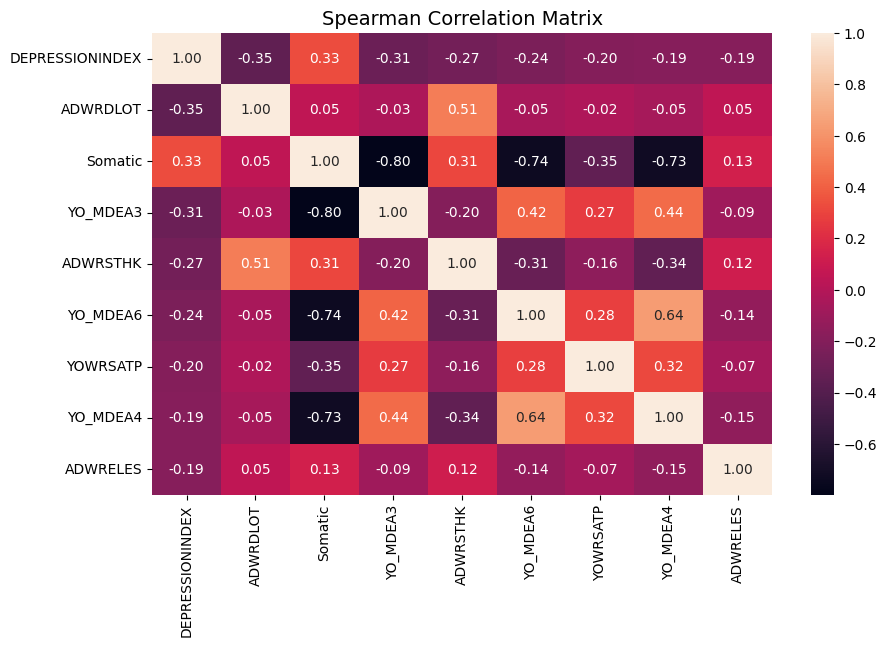

In [42]:
list_to_check = new_df_filtered_for_depressio_scale.corr(method='spearman')['DEPRESSIONINDEX'].abs().sort_values(ascending=False)
list_to_check_new = list_to_check[:9].index.tolist()
interesting_columns.append(list_to_check_new)
corr_data = new_df_filtered_for_depressio_scale[list_to_check_new]
corr_data.corr(method='spearman')
plt.figure(figsize=(10, 6))
sns.heatmap(corr_data.corr(method='spearman'), fmt=".2f", annot=True)
plt.title("Spearman Correlation Matrix",fontsize=14)
plt.show()

In [43]:
df_filtered_for_depressio_scale = df_filtered_for_depressio_scale[list_to_check_new]

# Modelowanie danych

## Podział zbioru na test, train, val

In [44]:
# index.append('DEPRESSIONINDEX')
# Boost_data = df_filtered[index]

# majority_class = Boost_data[Boost_data['DEPRESSIONINDEX'] == 0]
# minority_class = Boost_data[Boost_data['DEPRESSIONINDEX'] != 0]

# minority_oversampled = resample(minority_class, replace=True, n_samples=len(majority_class), random_state=42)

# Boost_data_2 = pd.concat([majority_class, minority_oversampled])

# X = Boost_data_2.drop(columns='DEPRESSIONINDEX')
# y = Boost_data_2['DEPRESSIONINDEX']

# y_binary = (y != 0).astype(int)


# X_train, X_test, y_train, y_test = train_test_split(X, y_binary, test_size=0.2, random_state=42)
# X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, test_size=0.5, random_state=42)

# X_train_2, X_test_2, y_train_2, y_test_2 = train_test_split(X, y, test_size=0.2, random_state=42)
# X_test_2, X_val_2, y_test_2, y_val_2 = train_test_split(X_test_2, y_test_2, test_size=0.5, random_state=42)


In [45]:
index.append('DEPRESSIONINDEX')
Boost_data = df_filtered[index]

majority_class = Boost_data[Boost_data['DEPRESSIONINDEX'] == 0]
minority_class = Boost_data[Boost_data['DEPRESSIONINDEX'] != 0]

minority_oversampled = resample(minority_class, replace=True, n_samples=len(majority_class), random_state=42)

Boost_data_binary = pd.concat([majority_class, minority_oversampled])

X_binary = Boost_data_binary.drop(columns='DEPRESSIONINDEX')
y_binary = (Boost_data_binary['DEPRESSIONINDEX'] != 0).astype(int)

X_train, X_test, y_train, y_test = train_test_split(X_binary, y_binary, test_size=0.2, random_state=42)
X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, test_size=0.5, random_state=42)


In [46]:
print(X_train.shape, X_val.shape, X_test.shape)
print(y_train.shape, y_val.shape, y_test.shape)

(48734, 6) (6092, 6) (6092, 6)
(48734,) (6092,) (6092,)


In [47]:
X_full = Boost_data.drop(columns='DEPRESSIONINDEX')
y_full = Boost_data['DEPRESSIONINDEX']

max_class_size = y_full.value_counts().head().values[1]

Boost_data_multi = pd.DataFrame()
for class_value in y_full.unique():
    class_subset = Boost_data[Boost_data['DEPRESSIONINDEX'] == class_value]
    class_resampled = resample(class_subset, replace=True, n_samples=max_class_size, random_state=42)
    Boost_data_multi = pd.concat([Boost_data_multi, class_resampled])

X_multi = Boost_data_multi.drop(columns='DEPRESSIONINDEX')
y_multi = Boost_data_multi['DEPRESSIONINDEX']

X_train_2, X_test_2, y_train_2, y_test_2 = train_test_split(X_multi, y_multi, test_size=0.2, random_state=42)
X_test_2, X_val_2, y_test_2, y_val_2 = train_test_split(X_test_2, y_test_2, test_size=0.5, random_state=42)


In [48]:
print(X_train_2.shape, X_val_2.shape, X_test_2.shape)
print(y_train_2.shape, y_val_2.shape, y_test_2.shape)

(12424, 6) (1553, 6) (1553, 6)
(12424,) (1553,) (1553,)


## Sprawdzenie rozkładu danych

### Test Kolmogorowa-Smirnowa by sprawdzić czy rozkład zmiennej Y jest taki sam

#### Dla klasyfikacji binarnej

In [49]:
stat, p_value = ks_2samp(y_train, y_val)
print(f'Test KS dla Train vs Validation: p-value={p_value}')

stat, p_value = ks_2samp(y_train, y_test)
print(f'Test KS dla Train vs Test: p-value={p_value}')

stat, p_value = ks_2samp(y_val, y_test)
print(f'Test KS dla Validation vs Test: p-value={p_value}')

Test KS dla Train vs Validation: p-value=0.9996798592546141
Test KS dla Train vs Test: p-value=0.9999999922751829
Test KS dla Validation vs Test: p-value=0.9999999999999996


#### Dla klasyfikacji wieloklasowej

In [50]:
stat, p_value = ks_2samp(y_train_2, y_val_2)
print(f'Test KS dla Train vs Validation: p-value={p_value}')
stat, p_value = ks_2samp(y_train_2, y_test_2)
print(f'Test KS dla Train vs Test: p-value={p_value}')
stat, p_value = ks_2samp(y_val_2, y_test_2)
print(f'Test KS dla Validation vs Test: p-value={p_value}')

Test KS dla Train vs Validation: p-value=0.9892134623115346
Test KS dla Train vs Test: p-value=0.1542731728018366
Test KS dla Validation vs Test: p-value=0.8966609039901413


### Test PCA by sprawdzić czy rozkładny zmiennej X są takie same

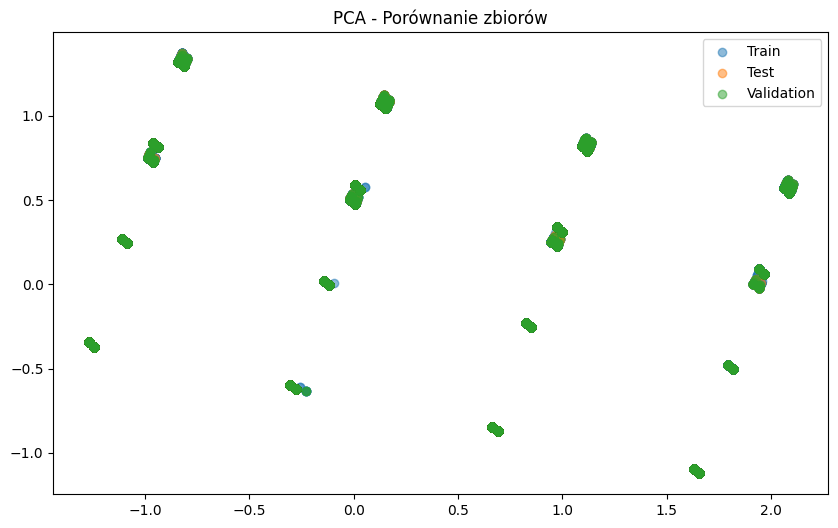

In [51]:
pca = PCA(n_components=2)

X_train_pca = pca.fit_transform(X_train)
X_val_pca = pca.transform(X_val)
X_test_pca = pca.transform(X_test)

plt.figure(figsize=(10, 6))
plt.scatter(X_train_pca[:, 0], X_train_pca[:, 1], label='Train', alpha=0.5)
plt.scatter(X_test_pca[:, 0], X_test_pca[:, 1], label='Test', alpha=0.5)
plt.scatter(X_val_pca[:, 0], X_val_pca[:, 1], label='Validation', alpha=0.5)

plt.legend()
plt.title('PCA - Porównanie zbiorów')
plt.show()

# Model do kalsyfikacji jest/nie ma depresji

## Model OLS

In [52]:
X_train_ols = sm.add_constant(X_train)
X_val_ols = sm.add_constant(X_val)

ols_model = sm.OLS(y_train, X_train_ols).fit()
predictions = ols_model.predict(X_val_ols)

probabilities = 1 / (1 + np.exp(-predictions))

threshold = 0.61
y_pred = (probabilities >= threshold).astype(int)


print(ols_model.summary())



                            OLS Regression Results                            
Dep. Variable:        DEPRESSIONINDEX   R-squared:                       0.104
Model:                            OLS   Adj. R-squared:                  0.103
Method:                 Least Squares   F-statistic:                     938.2
Date:                Sun, 26 Jan 2025   Prob (F-statistic):               0.00
Time:                        21:03:41   Log-Likelihood:                -32707.
No. Observations:               48734   AIC:                         6.543e+04
Df Residuals:                   48727   BIC:                         6.549e+04
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const             -0.0392      0.009     -4.

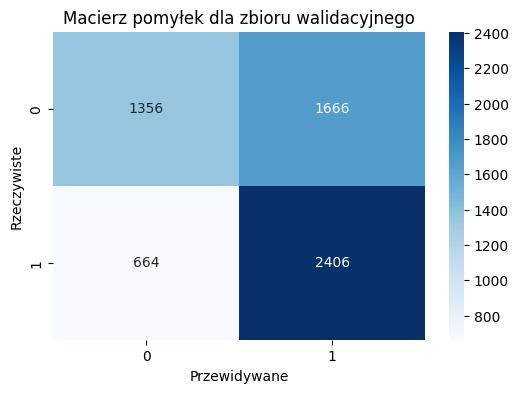

Accuracy: 0.62


In [53]:
conf_matrix = confusion_matrix(y_val, y_pred)

plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.title('Macierz pomyłek dla zbioru walidacyjnego')
plt.xlabel('Przewidywane')
plt.ylabel('Rzeczywiste')
plt.show()

accuracy = accuracy_score(y_val, y_pred)
print(f"Accuracy: {accuracy:.2f}")

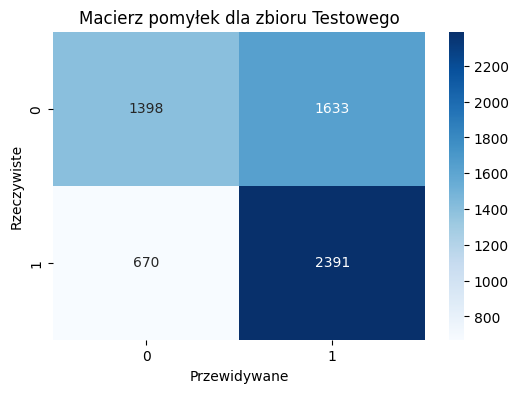

Accuracy: 0.62


In [54]:
X_test_ols = sm.add_constant(X_test)

predictions = ols_model.predict(X_test_ols)

probabilities = 1 / (1 + np.exp(-predictions))

threshold = 0.61
y_pred = (probabilities >= threshold).astype(int)

conf_matrix = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.title('Macierz pomyłek dla zbioru Testowego')
plt.xlabel('Przewidywane')
plt.ylabel('Rzeczywiste')
plt.show()

accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.2f}")

## Model XGB

In [55]:
model = xgb.XGBClassifier(n_estimators=300, max_depth=12, learning_rate=0.1, verbosity=1)
model.fit(X_train, y_train)
y_pred = model.predict(X_val)

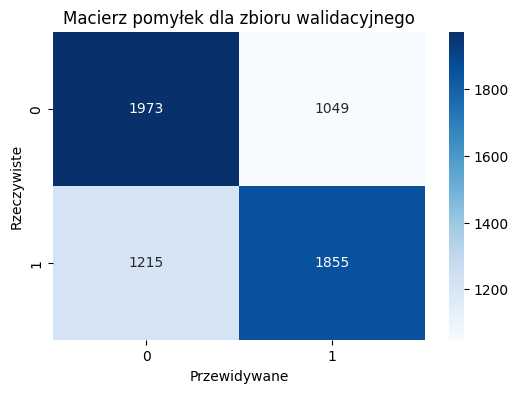

Accuracy: 0.63


In [56]:
conf_matrix = confusion_matrix(y_val, y_pred)

plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=model.classes_, yticklabels=model.classes_)
plt.title('Macierz pomyłek dla zbioru walidacyjnego')
plt.xlabel('Przewidywane')
plt.ylabel('Rzeczywiste')
plt.show()

accuracy = accuracy_score(y_val, y_pred)
print(f"Accuracy: {accuracy:.2f}")

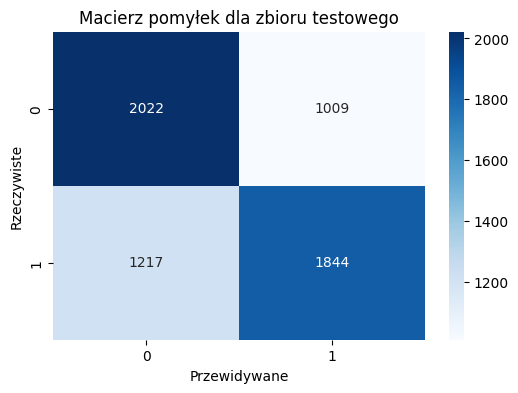

Accuracy: 0.63


In [57]:
y_pred = model.predict(X_test)

conf_matrix = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=model.classes_, yticklabels=model.classes_)
plt.title('Macierz pomyłek dla zbioru testowego')
plt.xlabel('Przewidywane')
plt.ylabel('Rzeczywiste')
plt.show()

accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.2f}")

# Model do kalsyfikacji skali depresji w całym zbiorze

## Model CatBoost

In [58]:
model = CatBoostClassifier(
    iterations=300,
    depth=12,
    learning_rate=0.1,
    verbose=50,
)

model.fit(X_train_2, y_train_2)

y_pred_2 = model.predict(X_val_2)

# print(classification_report(y_val_2, y_pred_2))

0:	learn: 2.2759436	total: 71.5ms	remaining: 21.4s
50:	learn: 2.1033370	total: 617ms	remaining: 3.01s
100:	learn: 2.0849760	total: 1.28s	remaining: 2.52s
150:	learn: 2.0754178	total: 3s	remaining: 2.96s
200:	learn: 2.0719617	total: 4.72s	remaining: 2.33s
250:	learn: 2.0701666	total: 6.44s	remaining: 1.26s
299:	learn: 2.0690584	total: 8.12s	remaining: 0us


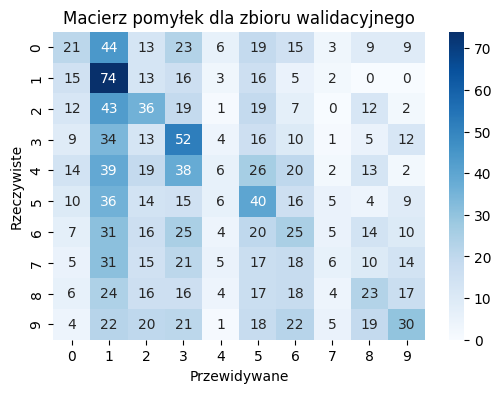

Accuracy: 0.20


In [59]:
cm = confusion_matrix(y_val_2, y_pred_2)

plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=model.classes_, yticklabels=model.classes_)
plt.title('Macierz pomyłek dla zbioru walidacyjnego')
plt.xlabel('Przewidywane')
plt.ylabel('Rzeczywiste')
plt.show()

accuracy = accuracy_score(y_val_2, y_pred_2)
print(f"Accuracy: {accuracy:.2f}")

## Model OLS

In [60]:
X_train_ols = sm.add_constant(X_train_2)
X_val_ols = sm.add_constant(X_val_2)

ols_model = sm.OLS(y_train_2, X_train_ols).fit()
predictions = ols_model.predict(X_val_ols)

# print(ols_model.summary())

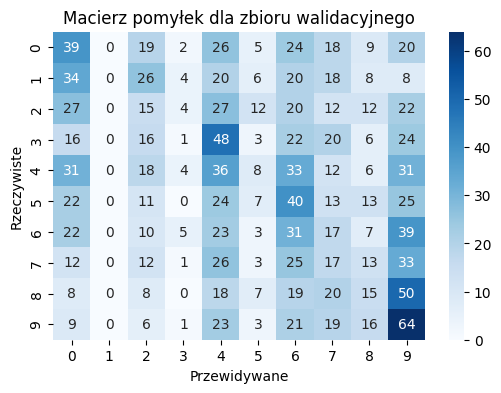

Accuracy: 0.14


In [61]:
min_pred = predictions.min()
max_pred = predictions.max()
predictions_normalized = (predictions - min_pred) / (max_pred - min_pred)

thresholds = [0, 0.08, 0.11, 0.2, 0.207, 0.29, 0.33, 0.4, 0.47, 0.53]

# Funkcja przypisująca klasy na podstawie thresholdów
def classify(predictions, thresholds):
    classes = np.zeros_like(predictions, dtype=int)  # Domyślne klasy to 0
    for i, thresh in enumerate(thresholds[:-1]):
        classes[(predictions >= thresh) & (predictions < thresholds[i + 1])] = i
    classes[predictions >= thresholds[-1]] = len(thresholds) - 1  # Ostatnia klasa
    return classes

# Klasyfikacja na podstawie progów
y_pred_classes = classify(predictions_normalized, thresholds)

conf_matrix = confusion_matrix(y_val_2, y_pred_classes)

plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=model.classes_, yticklabels=model.classes_)
plt.title('Macierz pomyłek dla zbioru walidacyjnego')
plt.xlabel('Przewidywane')
plt.ylabel('Rzeczywiste')
plt.show()

accuracy = accuracy_score(y_val_2, y_pred_classes)
print(f"Accuracy: {accuracy:.2f}")

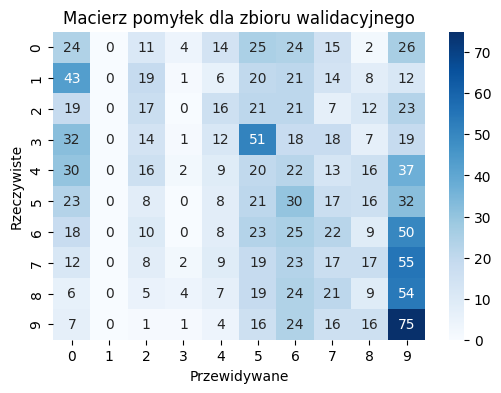

Accuracy: 0.13


In [62]:
X_test_ols = sm.add_constant(X_test_2)
predictions = ols_model.predict(X_test_ols)

min_pred = predictions.min()
max_pred = predictions.max()
predictions_normalized = (predictions - min_pred) / (max_pred - min_pred)

thresholds = [0 , 0.08373893, 0.11354783, 0.20212472, 0.20795749, 0.29481445, 0.33629996, 0.40240938, 0.47733972, 0.53905807]

# Funkcja przypisująca klasy na podstawie thresholdów
def classify(predictions, thresholds):
    classes = np.zeros_like(predictions, dtype=int)  # Domyślne klasy to 0
    for i, thresh in enumerate(thresholds[:-1]):
        classes[(predictions >= thresh) & (predictions < thresholds[i + 1])] = i
    classes[predictions >= thresholds[-1]] = len(thresholds) - 1  # Ostatnia klasa
    return classes

# Klasyfikacja na podstawie progów
y_pred_classes = classify(predictions_normalized, thresholds)

conf_matrix = confusion_matrix(y_test_2, y_pred_classes)

plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=model.classes_, yticklabels=model.classes_)
plt.title('Macierz pomyłek dla zbioru walidacyjnego')
plt.xlabel('Przewidywane')
plt.ylabel('Rzeczywiste')
plt.show()

accuracy = accuracy_score(y_test_2, y_pred_classes)
print(f"Accuracy: {accuracy:.2f}")

# Model do kalsyfikacji skali depresji gdy stwierdzono depresje

## Podział zbioru na test, train, val

In [63]:

new_boost_data = df_filtered_for_depressio_scale[df_filtered_for_depressio_scale['DEPRESSIONINDEX'] != 0]

groups = new_boost_data.groupby('DEPRESSIONINDEX')

max_samples_per_class = max(groups.size())  

balanced_data = groups.apply(
    lambda x: resample(x, replace=True, n_samples=max_samples_per_class*2, random_state=42)
)

balanced_data = balanced_data.reset_index(drop=True)

X = balanced_data.drop(columns='DEPRESSIONINDEX')
y = balanced_data['DEPRESSIONINDEX']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=36)
X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, test_size=0.5, random_state=36)



In [64]:
stat, p_value = ks_2samp(y_train, y_val)
print(f'Test KS dla Train vs Validation: p-value={p_value}')

stat, p_value = ks_2samp(y_train, y_test)
print(f'Test KS dla Train vs Test: p-value={p_value}')

stat, p_value = ks_2samp(y_val, y_test)
print(f'Test KS dla Validation vs Test: p-value={p_value}')

Test KS dla Train vs Validation: p-value=0.9564219649563003
Test KS dla Train vs Test: p-value=0.6655937271317294
Test KS dla Validation vs Test: p-value=0.9321768262973325


In [65]:
print(X_train.shape, X_val.shape, X_test.shape)
print(y_train.shape, y_val.shape, y_test.shape)

(23760, 8) (2097, 8) (2097, 8)
(23760,) (2097,) (2097,)


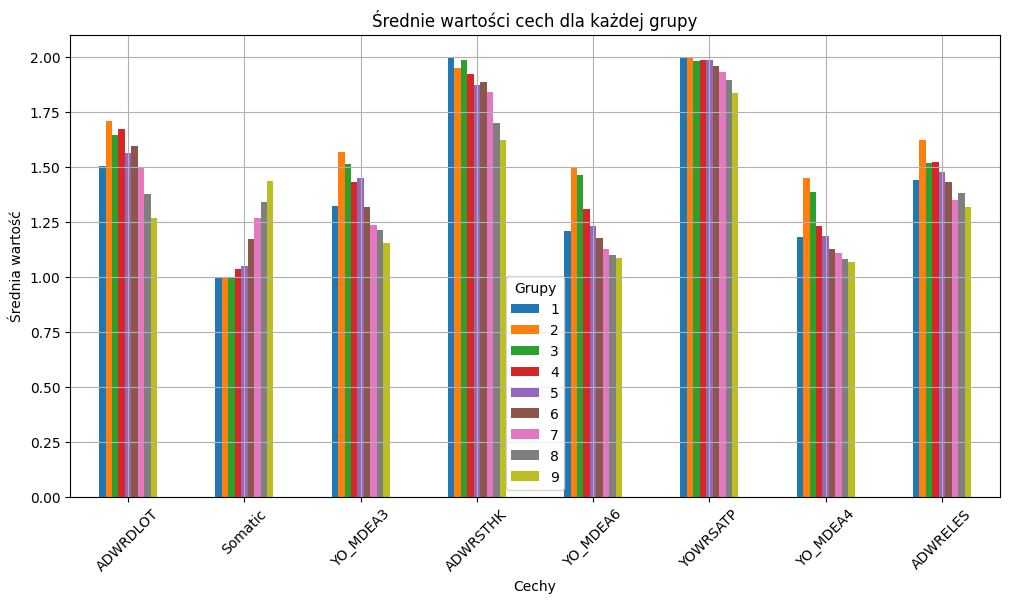

In [66]:
X_test['label'] = y_test
groups = X_test.groupby('label')
mean_features = groups.mean()

mean_features.T.plot(kind='bar', figsize=(12, 6))
plt.title('Średnie wartości cech dla każdej grupy')
plt.xlabel('Cechy')
plt.ylabel('Średnia wartość')
plt.xticks(rotation=45)
plt.legend(title='Grupy')
plt.grid(True)
plt.show()

Jak widać na wykresie istnieją znaczące różnice miedzy grupami dla każdej statystyki

## Model CatBoost

In [67]:
model_for_scale = CatBoostClassifier(
    iterations=2000,
    depth=6,
    learning_rate=0.01,
    verbose=500,
)

model_for_scale.fit(X_train, y_train)

y_pred = model_for_scale.predict(X_val)

print(classification_report(y_val, y_pred))

0:	learn: 2.1840692	total: 8.81ms	remaining: 17.6s
500:	learn: 1.5381925	total: 3.93s	remaining: 11.8s
1000:	learn: 1.5231439	total: 7.28s	remaining: 7.26s
1500:	learn: 1.5189145	total: 10.8s	remaining: 3.58s
1999:	learn: 1.5175414	total: 14.5s	remaining: 0us
              precision    recall  f1-score   support

           1       0.99      0.80      0.89       224
           2       0.35      0.74      0.47       219
           3       0.33      0.34      0.34       235
           4       0.30      0.12      0.17       233
           5       0.26      0.18      0.21       250
           6       0.22      0.26      0.24       234
           7       0.64      0.03      0.05       254
           8       0.25      0.41      0.31       229
           9       0.45      0.57      0.50       219

    accuracy                           0.37      2097
   macro avg       0.42      0.38      0.35      2097
weighted avg       0.42      0.37      0.35      2097



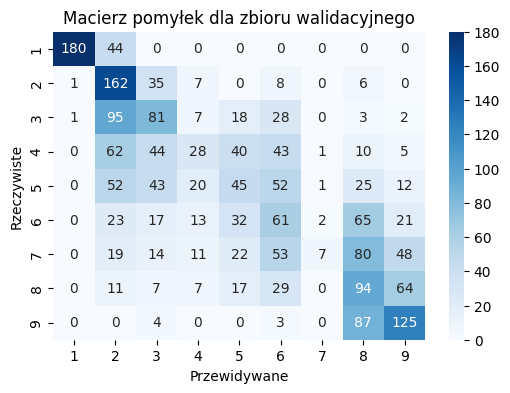

Accuracy: 0.37


In [68]:
conf_matrix = confusion_matrix(y_val, y_pred)

plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=model_for_scale.classes_, yticklabels=model_for_scale.classes_)
plt.title('Macierz pomyłek dla zbioru walidacyjnego')
plt.xlabel('Przewidywane')
plt.ylabel('Rzeczywiste')
plt.show()

accuracy = accuracy_score(y_val, y_pred)
print(f"Accuracy: {accuracy:.2f}")

## Model OLS

In [69]:
X_train_ols = sm.add_constant(X_train)
X_val_ols = sm.add_constant(X_val)

ols_model = sm.OLS(y_train, X_train_ols).fit()
predictions = ols_model.predict(X_val_ols)

print(ols_model.summary())

                            OLS Regression Results                            
Dep. Variable:        DEPRESSIONINDEX   R-squared:                       0.432
Model:                            OLS   Adj. R-squared:                  0.432
Method:                 Least Squares   F-statistic:                     2261.
Date:                Sun, 26 Jan 2025   Prob (F-statistic):               0.00
Time:                        21:04:13   Log-Likelihood:                -49560.
No. Observations:               23760   AIC:                         9.914e+04
Df Residuals:                   23751   BIC:                         9.921e+04
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         14.9937      0.195     76.732      0.0

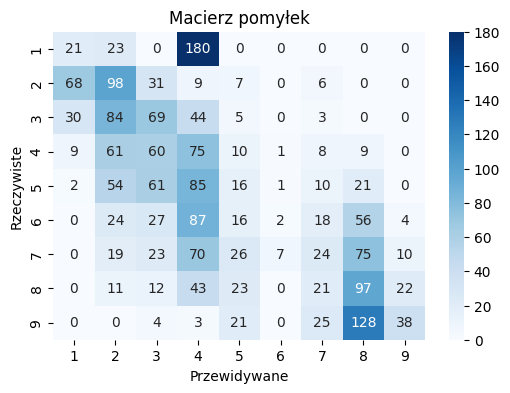

Accuracy: 0.21


In [70]:
min_val = predictions.min()
max_val = predictions.max()

bins = np.linspace(min_val, max_val, num=9)
y_pred_classes = np.digitize(predictions, bins=bins, right=True) +1

conf_matrix = confusion_matrix(y_val, y_pred_classes)

plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=model_for_scale.classes_, yticklabels=model_for_scale.classes_)
plt.title('Macierz pomyłek')
plt.xlabel('Przewidywane')
plt.ylabel('Rzeczywiste')
plt.show()

accuracy = accuracy_score(y_val, y_pred_classes)
print(f"Accuracy: {accuracy:.2f}")

# Analiza czynników wpływających na poziom depresji

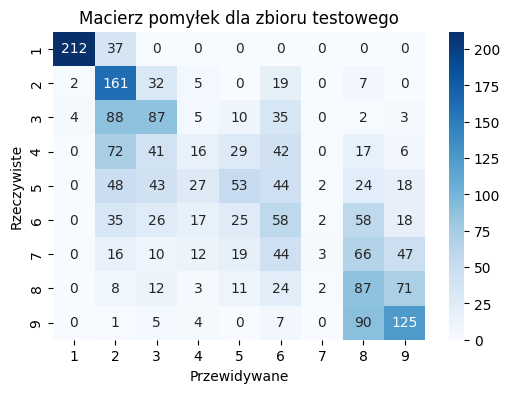

In [71]:
y_pred_2 = model_for_scale.predict(X_test)

conf_matrix = confusion_matrix(y_test, y_pred_2)

plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=model_for_scale.classes_, yticklabels=model_for_scale.classes_)
plt.title('Macierz pomyłek dla zbioru testowego')
plt.xlabel('Przewidywane')
plt.ylabel('Rzeczywiste')
plt.show()

Model analizy skali depresji na zbiorze testowym działa równie dobrze jak na walidacyjnym

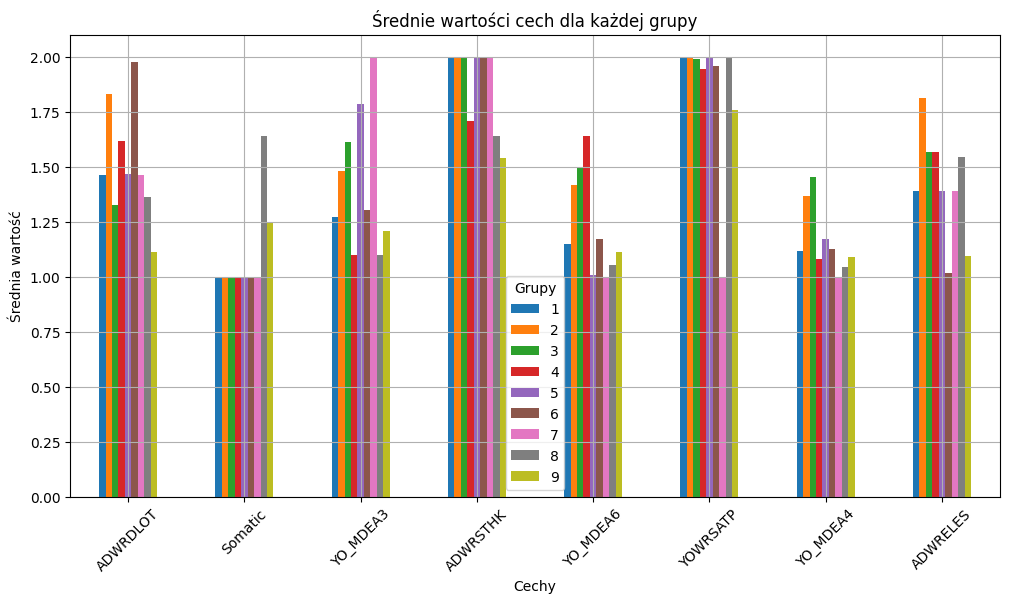

In [72]:
X_test.drop(columns='label', inplace=True)
X_test['label2'] = y_pred_2
groups = X_test.groupby('label2')
mean_features = groups.mean()

mean_features.T.plot(kind='bar', figsize=(12, 6))
plt.title('Średnie wartości cech dla każdej grupy')
plt.xlabel('Cechy')
plt.ylabel('Średnia wartość')
plt.xticks(rotation=45)
plt.legend(title='Grupy')
plt.grid(True)
plt.show()

Co ciekawe analiza przewidywanych grup nie daje nam już tak dobrych wyników jak wcześniej, choć różnice między wartościami średnimi w każdej z klas model nie odwzorował tych różnic w swoich predykcjach co może wynikać z tego że klasy 4 i 7 mają bardzo małą reprezentacje w zbiorze predykcji.

In [73]:
print("Średnie wartości cech dla każdej grupy:")
print(mean_features)


Średnie wartości cech dla każdej grupy:
        ADWRDLOT   Somatic  YO_MDEA3  ADWRSTHK  YO_MDEA6  YOWRSATP  YO_MDEA4  \
label2                                                                         
1       1.459754  1.000000  1.272696  2.000000  1.149742  2.000000  1.117627   
2       1.831898  1.000000  1.478713  2.000000  1.414307  2.000000  1.366055   
3       1.325060  1.000000  1.609366  2.000000  1.492107  1.988281  1.453808   
4       1.617578  1.000000  1.098048  1.707865  1.640933  1.943820  1.079307   
5       1.467104  1.000000  1.786023  2.000000  1.007131  2.000000  1.169667   
6       1.976253  1.000000  1.304665  2.000000  1.172464  1.956044  1.127108   
7       1.459754  1.000000  2.000000  2.000000  1.000000  1.000000  1.000000   
8       1.360241  1.641026  1.097891  1.641026  1.053753  2.000000  1.042225   
9       1.111746  1.243056  1.206416  1.538194  1.113346  1.756944  1.089037   

        ADWRELES  
label2            
1       1.389991  
2       1.810190  
3  

# A co gdyby skale depresji zmienić z 9 klas na 3 klasy charakteryzujące depresje

In [74]:
new_boost_data = df_filtered_for_depressio_scale[df_filtered_for_depressio_scale['DEPRESSIONINDEX'] != 0]

def map_to_new_classes(index):
    if index in [1, 2, 3]:
        return 'Class 1'
    elif index in [4, 5, 6]:
        return 'Class 2'
    elif index in [7, 8, 9]:
        return 'Class 3'

new_boost_data['NEW_DEPRESSIONINDEX'] = new_boost_data['DEPRESSIONINDEX'].apply(map_to_new_classes)

groups = new_boost_data.groupby('NEW_DEPRESSIONINDEX')

max_samples_per_class = max(groups.size())

balanced_data = groups.apply(
    lambda x: resample(x, replace=True, n_samples=max_samples_per_class*2, random_state=42)
)

balanced_data = balanced_data.reset_index(drop=True)

X = balanced_data.drop(columns=['DEPRESSIONINDEX', 'NEW_DEPRESSIONINDEX'])
y = balanced_data['NEW_DEPRESSIONINDEX']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=36)
X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, test_size=0.5, random_state=36)

print(f'Rozmiar zbioru treningowego: {X_train.shape}')
print(f'Rozmiar zbioru testowego: {X_test.shape}')
print(f'Rozmiar zbioru walidacyjnego: {X_val.shape}')

Rozmiar zbioru treningowego: (21471, 8)
Rozmiar zbioru testowego: (1894, 8)
Rozmiar zbioru walidacyjnego: (1895, 8)


In [75]:
stat, p_value = ks_2samp(y_train, y_val)
print(f'Test KS dla Train vs Validation: p-value={p_value}')

stat, p_value = ks_2samp(y_train, y_test)
print(f'Test KS dla Train vs Test: p-value={p_value}')

stat, p_value = ks_2samp(y_val, y_test)
print(f'Test KS dla Validation vs Test: p-value={p_value}')

Test KS dla Train vs Validation: p-value=0.9041037235260714
Test KS dla Train vs Test: p-value=0.97000712684821
Test KS dla Validation vs Test: p-value=0.5717426896981529


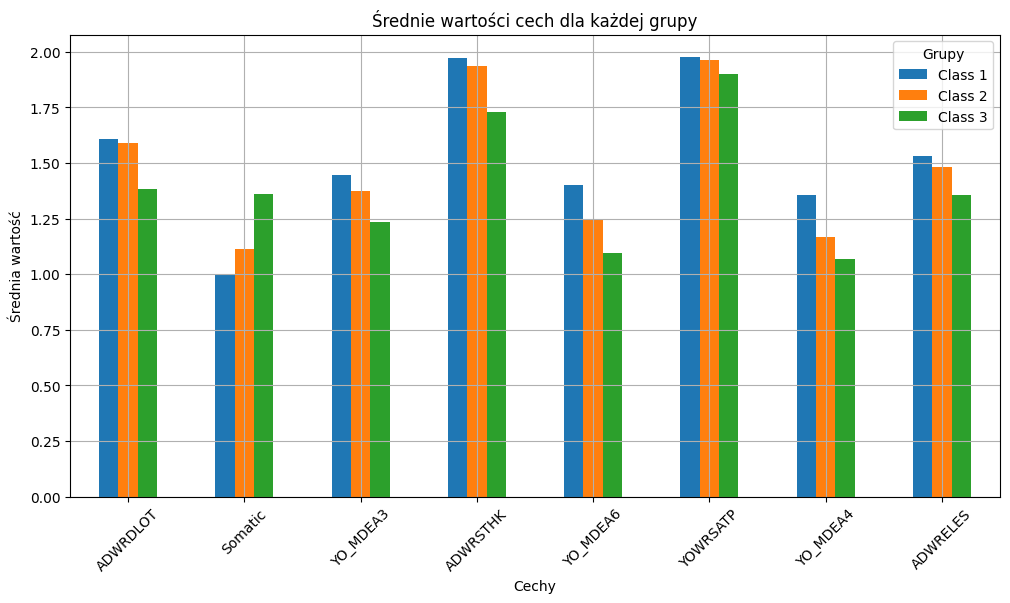

In [76]:
X_test['label'] = y_test
groups = X_test.groupby('label')
mean_features = groups.mean()

mean_features.T.plot(kind='bar', figsize=(12, 6))
plt.title('Średnie wartości cech dla każdej grupy')
plt.xlabel('Cechy')
plt.ylabel('Średnia wartość')
plt.xticks(rotation=45)
plt.legend(title='Grupy')
plt.grid(True)
plt.show()
X_test.drop(columns='label', inplace=True)

Analiza rozkładu średnich w poszczególnych grupach:  
ADWRDLOT - myśli o śmierci -  w każdej kolejnej grupie występuje więcej osób z myślami o śmierci   
Somatic - rodzaj depresji - w grupie 1 nie występuje depresja somatyczna a w każdej kolejnej odsetek osób rośnie   
YO_MDEA3 - zmiany apetytu - w każdej kolejnej grupie zwiększa się liczba osób z problemami z apetytem   
ADWRSTHK - chęć popełnienia samobójstwa - w grupie 1 i 2 mała grupa ma takie myśli a w grupie 3 występują one znacznie częściej    
YO_MDEA6 - brak energii - w każdej kolejnej grupie zwiększa się liczba osób wykazująca brak energii   
YOWRSATP - osoby z próbą samobójczą - w każdej kolejnej grupie rośnie liczba osób z próbą samobójczą lecz osób takich jest mało  
YO_MDEA4 - problemy ze snem - w każdej kolejnej grupie rośnie liczba osób z problemami ze snem  
ADWRELES - brak apetytu - w każdej kolejnej grupie rośnie liczba osób z brakiem apetytu  



In [77]:
model_for_scale = CatBoostClassifier(
    iterations=2000,
    depth=6,
    learning_rate=0.01,
    verbose=500,
)

model_for_scale.fit(X_train, y_train)

y_pred = model_for_scale.predict(X_val)

print(classification_report(y_val, y_pred))

0:	learn: 1.0917783	total: 5.46ms	remaining: 10.9s
500:	learn: 0.6843638	total: 1.55s	remaining: 4.64s
1000:	learn: 0.6768941	total: 3.17s	remaining: 3.16s
1500:	learn: 0.6748732	total: 4.75s	remaining: 1.58s
1999:	learn: 0.6741621	total: 6.18s	remaining: 0us
              precision    recall  f1-score   support

     Class 1       0.75      0.84      0.79       657
     Class 2       0.57      0.49      0.53       608
     Class 3       0.74      0.74      0.74       630

    accuracy                           0.70      1895
   macro avg       0.69      0.69      0.69      1895
weighted avg       0.69      0.70      0.69      1895



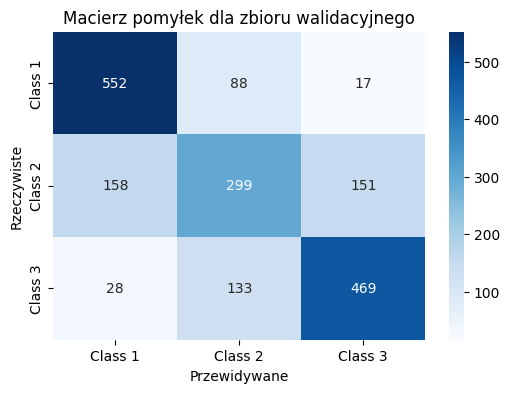

Accuracy: 0.70


In [78]:
conf_matrix = confusion_matrix(y_val, y_pred)

plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=model_for_scale.classes_, yticklabels=model_for_scale.classes_)
plt.title('Macierz pomyłek dla zbioru walidacyjnego')
plt.xlabel('Przewidywane')
plt.ylabel('Rzeczywiste')
plt.show()

accuracy = accuracy_score(y_val, y_pred)
print(f"Accuracy: {accuracy:.2f}")

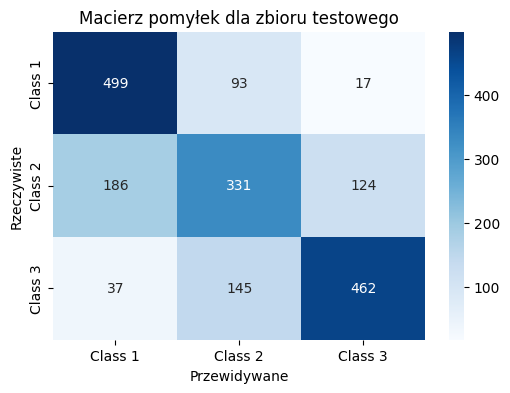

Accuracy: 0.68


In [79]:
y_pred_2 = model_for_scale.predict(X_test)

conf_matrix = confusion_matrix(y_test, y_pred_2)

plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=model_for_scale.classes_, yticklabels=model_for_scale.classes_)
plt.title('Macierz pomyłek dla zbioru testowego')
plt.xlabel('Przewidywane')
plt.ylabel('Rzeczywiste')
plt.show()


accuracy = accuracy_score(y_test, y_pred_2)
print(f"Accuracy: {accuracy:.2f}")

Model działa równie dobrze jak na zbiorze walidacyjnym

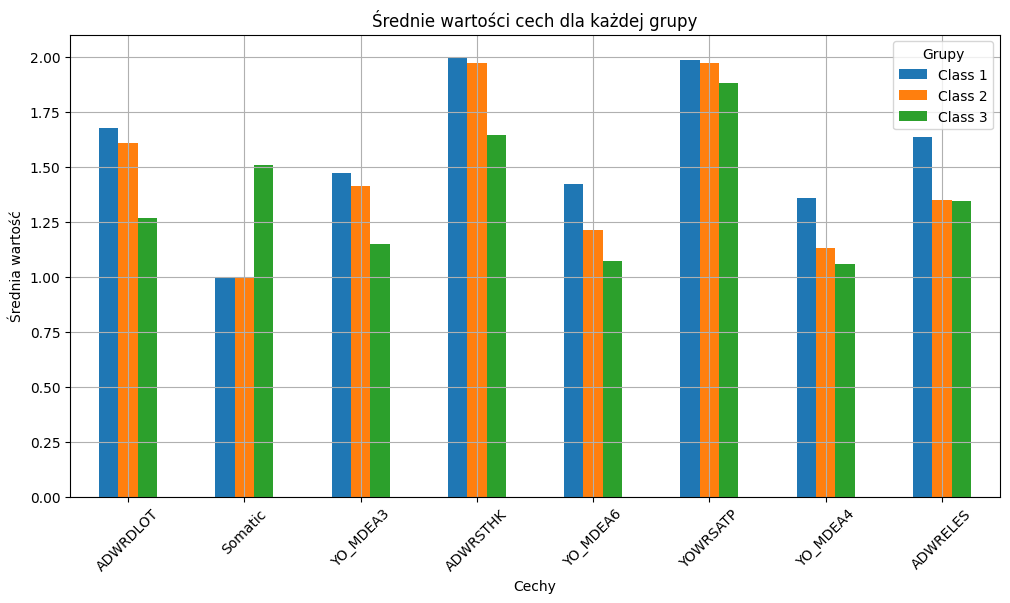

In [80]:
X_test['label'] = y_pred_2
groups = X_test.groupby('label')
mean_features = groups.mean()

mean_features.T.plot(kind='bar', figsize=(12, 6))
plt.title('Średnie wartości cech dla każdej grupy')
plt.xlabel('Cechy')
plt.ylabel('Średnia wartość')
plt.xticks(rotation=45)
plt.legend(title='Grupy')
plt.grid(True)
plt.show()
X_test.drop(columns='label', inplace=True)

Jak widać gdy zmniejszyliśmy skalę depresji z 9 pkt na 3 pkt model poradził sobie znacznie lepiej a średnie wartości każdej ze statystyk pokrywają się z wartościami prawidłowymi. Dzięki temu korzystając z modelu jesteśmy w stanie przypisać każdą z osób do odpowiedniej grupy i odpowiednio ją scharakteryzować